In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import sklearn as sk
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.spatial import cKDTree
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from pymer4.models import Lmer,Lm
from matplotlib import cm
from scipy.optimize import curve_fit
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



In [2]:
pd.set_option('display.max_columns', None)

In [3]:
concatenated_df = pd.read_pickle('./concatenated_df_oct.pkl')
age = pd.read_pickle('./age_oct.pkl')


average age: 30.741868131868134
average age controls: 35.067391304347844
average age encephalitis: 28.807199999999998
average age schizophrenia: 23.2115


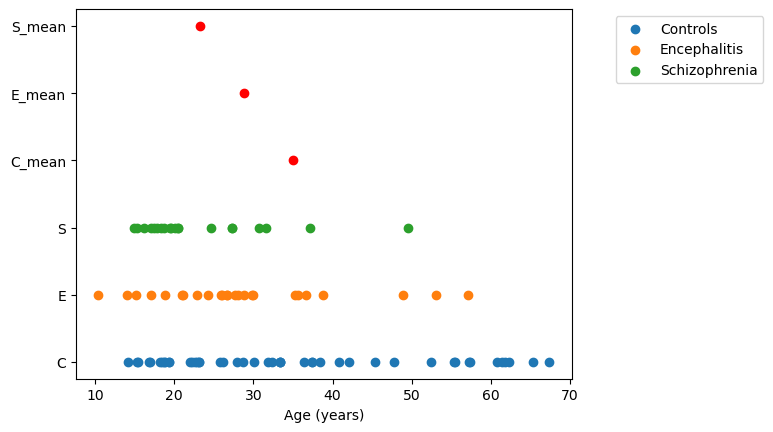

In [4]:
age['Group'] = age['Subject'].str[0]
age.tail(9)


# Session 1
print('average age:', np.mean(age.loc[age['Session']==1, 'Age']))
print('average age controls:', np.mean(age.loc[((age['Group']=='C')&(age['Session']==1)), 'Age']))
print('average age encephalitis:', np.mean(age.loc[((age['Group']=='E')&(age['Session']==1)), 'Age']))
print('average age schizophrenia:', np.mean(age.loc[((age['Group']=='S')&(age['Session']==1)), 'Age']))

# plot age
plt.scatter(age.loc[((age['Group']=='C')&(age['Session']==1)), 'Age'], age.loc[((age['Group']=='C')&(age['Session']==1)), 'Group'], label = 'Controls')
plt.scatter(age.loc[((age['Group']=='E')&(age['Session']==1)), 'Age'], age.loc[((age['Group']=='E')&(age['Session']==1)), 'Group'], label = 'Encephalitis')
plt.scatter(age.loc[((age['Group']=='S')&(age['Session']==1)), 'Age'], age.loc[((age['Group']=='S')&(age['Session']==1)), 'Group'], label = 'Schizophrenia')
plt.legend(bbox_to_anchor=(1.4, 1.0))
  
plt.errorbar(np.mean(age.loc[((age['Group']=='C')&(age['Session']==1)), 'Age']), "C_mean", xerr=stats.sem(age.loc[((age['Group']=='C')&(age['Session']==1)), 'Age']), marker="o", color = 'r')
plt.errorbar(np.mean(age.loc[((age['Group']=='E')&(age['Session']==1)), 'Age']), "E_mean", xerr=stats.sem(age.loc[((age['Group']=='C')&(age['Session']==1)), 'Age']), marker="o", color = 'r')
plt.errorbar(np.mean(age.loc[((age['Group']=='S')&(age['Session']==1)), 'Age']), "S_mean", xerr=stats.sem(age.loc[((age['Group']=='C')&(age['Session']==1)), 'Age']), marker="o", color = 'r')

plt.xlabel('Age (years)')
plt.savefig('Age variance', bbox_inches='tight')
plt.show()




In [5]:
def fill_na_mode(group):
    mode = group.mode()
    if len(mode) > 0:
        return group.fillna(mode.iloc[0])
    else:
        return group

age['sex'] = age.groupby('Subject')['M/F'].transform(fill_na_mode)


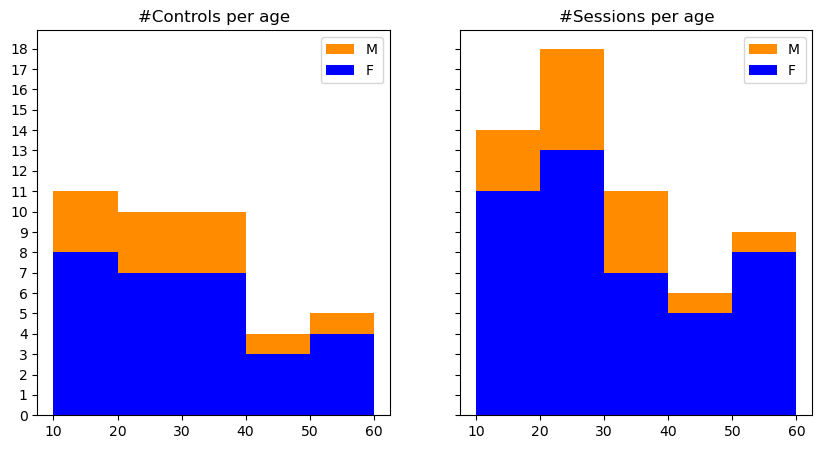

In [6]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5), sharex = 'all', sharey = 'all')


ax[0].hist(age.loc[((age['Group']=='C')&(age['Session']==1)), 'Age'],color='darkorange',bins=[10, 20, 30, 40, 50, 60], label = 'M')
ax[0].hist(age.loc[((age['Group']=='C')&(age['Session']==1)&(age['sex']=='F')), 'Age'], color = 'blue',bins=[10, 20, 30, 40, 50, 60], label = 'F')
ax[0].set_yticks(np.arange(0, 20, step=1))
ax[0].legend()
ax[0].set_title('#Controls per age')

ax[1].hist(age.loc[((age['Group']=='C')), 'Age'],bins=[10, 20, 30, 40, 50, 60],color='darkorange', label = 'M')
ax[1].hist(age.loc[((age['Group']=='C')&(age['sex']=='F')), 'Age'], color = 'blue',bins=[10, 20, 30, 40, 50, 60], label = 'F')
ax[1].legend()
ax[1].set_title('#Sessions per age')

plt.show()


In [7]:
# Subsets data
crs1 = concatenated_df['Session']==1
crs2 = concatenated_df['Session']==2
crs3 = concatenated_df['Session']==3
crs4 = concatenated_df['Session']==4

cri1 = concatenated_df['Group'] == 'C'
cri2 = concatenated_df['Group'] == 'E'
cri3 = concatenated_df['Group'] == 'S'
criC = cri1 & crs1
criE = cri2 & crs1
criS = cri3 & crs1

# Only data from session 1
#data = concatenated_df[crs1]
data=concatenated_df

# Add confusional arousals
cfsubj = ['E02','E03','E05','E06','E07','E16','E21','E22','C11','C12','C14','C18']
data['ConfArousal'] = 0
data.loc[concatenated_df.Subject.isin(cfsubj),'ConfArousal'] = 1
data.loc[:,'ConfArousal'] = data.loc[:,'ConfArousal'].astype('category')


# select frontal and posterior channels
chan_fp = ['Fp1', 'Fpz', 'Fp2', 'AF7', 'AFz', 'AF8', 'F7', 'F8', 'F3','Fz', 'F4', 'F8', 'P3', 'Pz', 'P4', 'PO7', 'PO3', 
           'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2']
data_fp = concatenated_df[concatenated_df.Channel.isin(chan_fp)]

# add column indicating whether frontal or posterior electrode
#chan_f = ['Fz','F3','F4']
chan_f = ['Fz','F3','F4','F7','F8']
data_fp['Position'] = 'P'
data_fp.loc[data_fp.Channel.isin(chan_f),'Position'] = 'F'
data_fp.loc[:,'Session'] = data_fp.loc[:,'Session'].astype(int)


/tmp/ipykernel_431155/3263902381.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_fp['Position'] = 'P'


## AGE COMPRISON between 20- and 20+

In [8]:
data_F = data_fp.copy()
data_F = data_F[data_F['Position'] == 'F'].reset_index(drop=True)
data_F.head()

Wave     Start  NegPeak  MidCrossing  PosPeak      End  Duration  \
0  16147  0.390689  1406.81      1407.16  1407.77  1408.12      1.64   
1  11458  0.391044  1408.03      1408.31  1408.67  1409.26      1.50   
2  14355  0.393181  1415.75      1416.35  1416.68  1416.93      1.48   
3  11459  0.393536  1417.03      1417.28  1417.47  1417.69      0.96   
4  14356  0.397639  1431.74      1431.96  1432.18  1432.82      1.32   

   ValNegPeak  ValPosPeak         PTP       Slope  Frequency  Stage Channel  \
0  -54.438037   56.538966  110.977003  317.077151   0.609756      2      F4   
1  -59.791872   41.681846  101.473718  362.406135   0.666667      2      F7   
2  -43.574775   38.377907   81.952683  136.587804   0.675676      2      Fz   
3  -82.223783   45.544797  127.768579  511.074318   1.041667      2      F7   
4  -42.860329   34.949432   77.809761  353.680731   0.757576      2      Fz   

   IdxChannel Group Subject Session    Age Machine ConfArousal Position  
0           9     C     C02       1  22.91       O           0        F  
1           6     C     C02       1  22.91       O           0        F  
2           8     C     C02       1  22.91       O           0        F  
3           6     C     C02       1  22.91       O           0        F  
4           8     C     C02       1  22.91       O           0        F

In [9]:
data_F[data_F['Stage'] == 3]['Start']

47        0.673000
48        0.679381
49        0.679381
50        0.679381
51        0.679381
            ...   
843546    5.718425
843547    5.722625
843548    5.722628
843549    5.722950
843737    6.576497
Name: Start, Length: 559209, dtype: float64

In [10]:
data_F['Start']

0         0.390689
1         0.391044
2         0.393181
3         0.393536
4         0.397639
            ...   
844182    7.966611
844183    7.966636
844184    7.971547
844185    7.982069
844186    7.982247
Name: Start, Length: 844187, dtype: float64

In [11]:
data_F['Id'] = data_F['Subject'] + '_' + data_F['Session'].astype(str)

In [12]:
data_prov = data_F[data_F['Id']=='E18_1']
data_prov = data_prov[data_prov['Stage']==3]
data_prov

Wave     Start   NegPeak  MidCrossing   PosPeak       End  Duration  \
604345  6710  0.371167   1336.47      1336.70   1336.92   1337.25      1.05   
604346  5625  0.371175   1336.49      1336.72   1336.93   1337.24      1.01   
604347  8002  0.371178   1336.49      1336.72   1336.92   1337.17      0.93   
604348  5277  0.377364   1358.78      1359.03   1359.22   1359.96      1.45   
604349  8003  0.377375   1358.80      1359.05   1359.24   1359.98      1.43   
...      ...       ...       ...          ...       ...       ...       ...   
607553  6575  3.968572  14287.11     14287.35  14287.61  14287.93      1.07   
607554  8765  3.968572  14287.10     14287.35  14287.60  14288.03      1.17   
607555  7832  3.968575  14287.10     14287.35  14287.67  14288.04      1.17   
607556  5561  3.968594  14287.17     14287.41  14287.67  14287.99      1.05   
607842  8839  6.080450  21889.96     21890.20  21890.42  21890.75      1.13   

        ValNegPeak  ValPosPeak         PTP       Slope  Frequency  Stage  \
604345  -58.338019   48.150222  106.488242  462.992356   0.952381      3   
604346  -55.085696   45.797556  100.883251  438.622832   0.990099      3   
604347  -56.757571   36.740741   93.498312  406.514399   1.075269      3   
604348  -60.205166   32.563511   92.768677  371.074707   0.689655      3   
604349  -63.795980   30.869668   94.665648  378.662592   0.699301      3   
...            ...         ...         ...         ...        ...    ...   
607553  -97.759993   78.960425  176.720418  736.335075   0.934579      3   
607554  -58.026169   35.295716   93.321885  373.287538   0.854701      3   
607555  -86.413366   60.976577  147.389942  589.559770   0.854701      3   
607556  -52.979018   50.911554  103.890572  432.877383   0.952381      3   
607842  -69.152539   54.481036  123.633575  515.139896   0.884956      3   

       Channel  IdxChannel Group Subject Session    Age Machine ConfArousal  \
604345      Fz           8     E     E18       1  25.91       N           0   
604346      F3           7     E     E18       1  25.91       N           0   
604347      F4           9     E     E18       1  25.91       N           0   
604348      F7           6     E     E18       1  25.91       N           0   
604349      F4           9     E     E18       1  25.91       N           0   
...        ...         ...   ...     ...     ...    ...     ...         ...   
607553      F3           7     E     E18       1  25.91       N           0   
607554      F4           9     E     E18       1  25.91       N           0   
607555      Fz           8     E     E18       1  25.91       N           0   
607556      F7           6     E     E18       1  25.91       N           0   
607842      F4           9     E     E18       1  25.91       N           0   

       Position     Id  
604345        F  E18_1  
604346        F  E18_1  
604347        F  E18_1  
604348        F  E18_1  
604349        F  E18_1  
...         ...    ...  
607553        F  E18_1  
607554        F  E18_1  
607555        F  E18_1  
607556        F  E18_1  
607842        F  E18_1  

[2798 rows x 23 columns]

In [13]:
data_F['Id'] = data_F['Subject'] + '_' + data_F['Session'].astype(str)
data_F['time_n'] = data_F['Start']
time_threshold = 0.005
slope_threshold = 0.20

def filter_group(group):
    tree = cKDTree(group[['time_n', 'Slope']])
    pairs = tree.query_pairs(r=np.sqrt(time_threshold**2 + slope_threshold**2))
    keep = np.ones(len(group), dtype=bool)
    for i, j in pairs:
        keep[j] = False
    return group[keep]

data_F = data_F.groupby('Id', group_keys=False).apply(filter_group).drop(columns=['time_n']).reset_index(drop=True)


(0.0, 1.0)

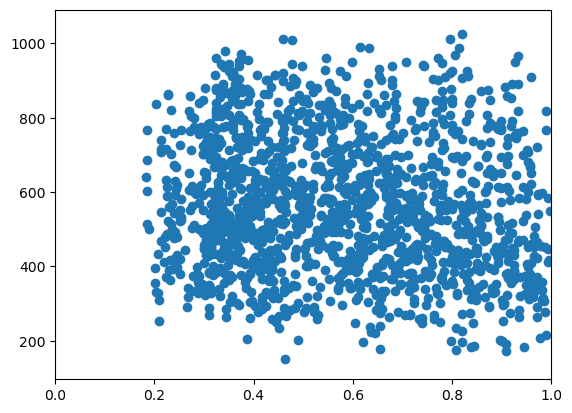

In [14]:
data_prov = data_F[data_F['Id']=='C47_1']
plt.scatter(data_prov['Start'],data_prov['Slope'])
plt.xlim([0,1])

In [15]:
data_F.groupby('Id')

In [16]:

def find_next_bigger(sorted_array, value1):
    for num in sorted_array:
        if num > value1:
            return num
    
    return None

def first_block_all(data, data_n3, bin_size, threshold_sum,id):
    if len(data_n3) < threshold_sum:
         return None

    hist_values, bin_edges = np.histogram(data, bins=np.arange(0, round(max(data),2) + bin_size, bin_size))
    hist_valuesn3, bin_edgesn3 = np.histogram(data_n3, bins=np.arange(0, round(max(data_n3),2) + bin_size, bin_size))

    nz_indices = np.where(hist_values > 10)[0]
    nz_indices3 = np.where(hist_valuesn3 > 10)[0]

    nz_edges = np.round(bin_edges[nz_indices],2)
    nz_edges3 = np.round(bin_edgesn3[nz_indices3],2)

    cbins = [nz_edges3[0]]
    if id == 'C07_1':
        print(nz_edges)

    if nz_edges[0] > cbins[0]:
        nz_edges = np.concatenate(([cbins[0]], nz_edges))

    for i in range(1, len(nz_edges)): 
        if nz_edges[i] in nz_edges3 or nz_edges[i] > cbins[0]:
            if round(nz_edges[i] - nz_edges[i - 1],2) == bin_size:
                if id == 'C07_1':
                 print(nz_edges[i])
                cbins.append(nz_edges[i])
            else:
                if (sum(hist_values[np.searchsorted(bin_edges, cbins[0]):np.searchsorted(bin_edges, cbins[-1])]) > threshold_sum):
                    if id == 'C07_1':
                        print(cbins)
                        print(sum(hist_values[np.searchsorted(bin_edges, cbins[0]):np.searchsorted(bin_edges, cbins[-1])]))
                    return cbins[0]

                if nz_edges[i] in nz_edges3:
                    cbins = [nz_edges[i]]
                else:
                    if find_next_bigger(nz_edges3, nz_edges[i]) is not None:
                        cbins = [find_next_bigger(nz_edges3, nz_edges[i])]
                    else:
                        return None

    if sum(hist_values[np.searchsorted(bin_edges, cbins[0]):np.searchsorted(bin_edges, cbins[-1])]) > threshold_sum:
                if id == 'C07_1':
                        print(cbins)
                        print(sum(hist_values[np.searchsorted(bin_edges, cbins[0]):np.searchsorted(bin_edges, cbins[-1])]))
                return cbins[0]
    return None



data_starts = data_F.groupby('Id').apply(
    lambda x: first_block_all(
        data=x['Start'],
        data_n3=x[x['Stage'] == 3]['Start'],
        bin_size=0.05,
        threshold_sum=350,
        id = x['Id'].values[0]
    )
).reset_index(name='Start_Block')




[0.85 0.9  0.95 1.   1.05 1.1  1.2  1.25 1.45 2.25 2.3  2.4  2.45 2.5
 2.55 2.65 3.55 3.95 4.75 4.8  4.85 6.25 6.3  6.35 6.4  6.45 6.5  6.55
 6.6 ]
0.9
0.95
1.0
1.05
1.1
2.3
2.45
2.5
2.55
4.8
4.85
6.3
6.35
6.4
6.45
6.5
6.55
6.6


In [17]:
data_F = data_F[data_F['Age']<21]


In [18]:
data_starts[data_starts['Id']=='C07_1']

Id  Start_Block
7  C07_1          NaN

In [19]:
data_F

Wave     Start   NegPeak  MidCrossing   PosPeak       End  Duration  \
23149   17164  0.326231   1174.75      1175.00   1175.20   1175.44      1.01   
23150   24749  0.326244   1174.77      1175.01   1175.23   1175.53      1.05   
23151   27469  0.326244   1174.78      1175.00   1175.26   1175.97      1.49   
23152   19166  0.331553   1193.88      1194.14   1194.37   1194.67      1.08   
23153   21864  0.331564   1193.90      1194.15   1194.37   1194.62      0.99   
...       ...       ...       ...          ...       ...       ...       ...   
642064  18543  7.966611  28680.11     28680.40  28680.63  28681.26      1.46   
642065  29095  7.966636  28680.17     28680.46  28680.70  28681.07      1.18   
642066  27450  7.971547  28698.09     28698.40  28698.71  28699.28      1.71   
642067  24612  7.982069  28736.41     28736.68  28736.87  28737.16      1.71   
642068  21567  7.982247  28736.42     28736.71  28736.88  28737.13      1.04   

        ValNegPeak  ValPosPeak         PTP       Slope  Frequency  Stage  \
23149   -72.984372   47.346730  120.331102  481.324408   0.990099      2   
23150  -123.103197  105.883531  228.986728  954.111366   0.952381      2   
23151   -59.576020   67.637176  127.213196  578.241801   0.671141      2   
23152   -57.275506   36.302239   93.577746  359.914407   0.925926      2   
23153   -63.588538   48.854137  112.442675  449.770701   1.010101      2   
...            ...         ...         ...         ...        ...    ...   
642064 -116.404911   63.626076  180.030987  620.796507   0.684932      2   
642065  -50.067150   27.750825   77.817975  268.337845   0.847458      2   
642066  -94.930981   79.295763  174.226745  562.021757   0.584795      2   
642067  -75.461099   42.263394  117.724493  436.016639   0.584795      2   
642068  -61.394753   23.589846   84.984598  293.050339   0.961538      2   

       Channel  IdxChannel Group Subject Session   Age Machine ConfArousal  \
23149       F7           6     C     C06       1  14.2       O           0   
23150       F4           9     C     C06       1  14.2       O           0   
23151       F8          10     C     C06       1  14.2       O           0   
23152       F3           7     C     C06       1  14.2       O           0   
23153       Fz           8     C     C06       1  14.2       O           0   
...        ...         ...   ...     ...     ...   ...     ...         ...   
642064      F7           6     S     S22       1  18.3       N           0   
642065      F8          10     S     S22       1  18.3       N           0   
642066      F4           9     S     S22       1  18.3       N           0   
642067      Fz           8     S     S22       1  18.3       N           0   
642068      F3           7     S     S22       1  18.3       N           0   

       Position     Id  
23149         F  C06_1  
23150         F  C06_1  
23151         F  C06_1  
23152         F  C06_1  
23153         F  C06_1  
...         ...    ...  
642064        F  S22_1  
642065        F  S22_1  
642066        F  S22_1  
642067        F  S22_1  
642068        F  S22_1  

[314789 rows x 23 columns]

data_F = data_F[data_F.Id != 'E17_1']
data_F = data_F[data_F.Id != 'E17_3']
data_F = data_F[data_F.Id != 'C07_4']
data_F = data_F[data_F.Id != 'E07_1']
data_F = data_F[data_F.Id != 'E02_3']

In [20]:
data_F['N23_times'] = data_F['Id'].map(data_starts.set_index('Id')['Start_Block'])
data_F = data_F.dropna(subset=['N23_times'])
data_F['time_rel'] = data_F['Start'] - data_F['N23_times']
data_F = data_F[data_F['time_rel'] >= 0]

data_F['N3_times'] = data_F['Start'].where(data_F['Stage'] == 3)
N3_start_time = data_F.groupby(['Subject','Session'])['N3_times'].transform('min')
data_F['N3_times'] = N3_start_time
data_F['time_rel'] = data_F['Start'] - data_F['N3_times']

data_F['diff'] = data_F['N3_times'] - data_F['N23_times']

data_allF = data_F[(data_F['time_rel'] <= 0.5) & (data_F['time_rel'] >= 0)]
#data_allF = data_allF[(data_allF['Stage'] == 3) | (data_allF['time_rel'] >= 0.2)]

data_allF = data_allF.dropna(subset=['Age'])

/tmp/ipykernel_431155/3527459304.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_F['N23_times'] = data_F['Id'].map(data_starts.set_index('Id')['Start_Block'])
/tmp/ipykernel_431155/3527459304.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_F['time_rel'] = data_F['Start'] - data_F['N23_times']


data_F['Id'] = data_F['Subject'] + '_' + data_F['Session'].astype(str)

data_F['condBlock'] = 0
for index, row in data_F.iterrows():
    if row['Stage'] == 3:
        t0 = row['Start']
        t0_5 = t0 + 0.5
        id = row['Id']
        data_Id = data_F.where(data_F['Id'] == id)
        data_Id['N3'] = data_Id['Stage'].apply(lambda x: 1 if x == 3 else 0)
        c = data_Id[(data_Id['Start'] > t0) & (data_Id['Start'] <= t0_5)] 
        c = c['N3'].eq(1).sum()
        if c >= 100:
            row['condBlock'] = 1

In [21]:
result_df = data_allF.groupby('Id')['diff'].first().reset_index()
result_df[0:60]



Id      diff
0   C06_1  0.006942
1   C06_4  0.008653
2   C10_1  0.005103
3   C10_4  0.018286
4   C11_1  0.019064
5   C12_1  0.011703
6   C14_1  0.002992
7   C14_4  0.000692
8   C15_1  0.034231
9   C15_4  0.009036
10  C18_1  0.027861
11  C20_1  0.008125
12  C20_4  0.016769
13  C36_1  0.011111
14  C38_1  0.009478
15  E02_1  0.033803
16  E02_2  0.005336
17  E02_3  0.025567
18  E02_4  0.017108
19  E04_1  0.008714
20  E04_2  0.002717
21  E04_3  0.016703
22  E04_4  0.004489
23  E07_1  0.042097
24  E07_2  0.022300
25  E07_3  0.002947
26  E07_4  0.000494
27  E17_1  0.005917
28  E17_3  0.008408
29  S03_1  0.027261
30  S03_4  0.000069
31  S04_1  0.028289
32  S06_1  0.008319
33  S07_4  0.008892
34  S08_1  0.023433
35  S08_4  0.034369
36  S09_1  0.025667
37  S11_1  0.000656
38  S11_4  0.022869
39  S12_1  0.004978
40  S14_1  0.007544
41  S15_1  0.042283
42  S15_4  0.002825
43  S19_1  0.009844
44  S21_1  0.026894
45  S22_1  0.001778

In [22]:
data_18_3 = data_allF[data_allF['Stage']==3]
data_18_3[data_18_3['Id']=='E18_4']['Start']

Series([], Name: Start, dtype: float64)

In [23]:
result_df = data_allF.groupby('Id')['N3_times'].first().reset_index()
result_df[75:125]


Empty DataFrame
Columns: [Id, N3_times]
Index: []

In [24]:
data_allF[data_allF['Id'] == 'C02_1'].head(9)

Empty DataFrame
Columns: [Wave, Start, NegPeak, MidCrossing, PosPeak, End, Duration, ValNegPeak, ValPosPeak, PTP, Slope, Frequency, Stage, Channel, IdxChannel, Group, Subject, Session, Age, Machine, ConfArousal, Position, Id, N23_times, time_rel, N3_times, diff]
Index: []

In [25]:

#SEPARATE BINNED DATA_F in 20- and 20+

bins_data_F = data_allF.copy()
bins_data_F = bins_data_F[bins_data_F['Session']==1]
bins_data_F['time_rel'] = pd.cut(bins_data_F['time_rel'], bins=8)  # Adjust the number of bins as needed


print (len(bins_data_F))

#older group
bdf_o = bins_data_F[bins_data_F['Age'] > 35]
print(len(bdf_o))

bdf_o = bdf_o.groupby(['Session','Subject','time_rel'])['Slope'].mean().reset_index()
bdf_o['Group'] = bdf_o['Subject'].str[0]
mdf_o = bdf_o.groupby(['Group','time_rel'])['Slope'].agg(['mean', 'sem']).reset_index()

#younger group
bdf_y = bins_data_F[bins_data_F['Age'] <= 35]
print(len(bdf_y))

bdf_y = bdf_y.groupby(['Session','Subject','time_rel'])['Slope'].mean().reset_index()
bdf_y['Group'] = bdf_y['Subject'].str[0]
mdf_y = bdf_y.groupby(['Group','time_rel'])['Slope'].agg(['mean', 'sem']).reset_index()

#all
bins_data_F = bins_data_F.groupby(['Session','Subject','time_rel'])['Slope'].mean().reset_index()
bins_data_F['Group'] = bins_data_F['Subject'].str[0]
mean_data_F = bins_data_F.groupby(['Group','time_rel'])['Slope'].agg(['mean', 'sem']).reset_index()


36822
0
36822


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


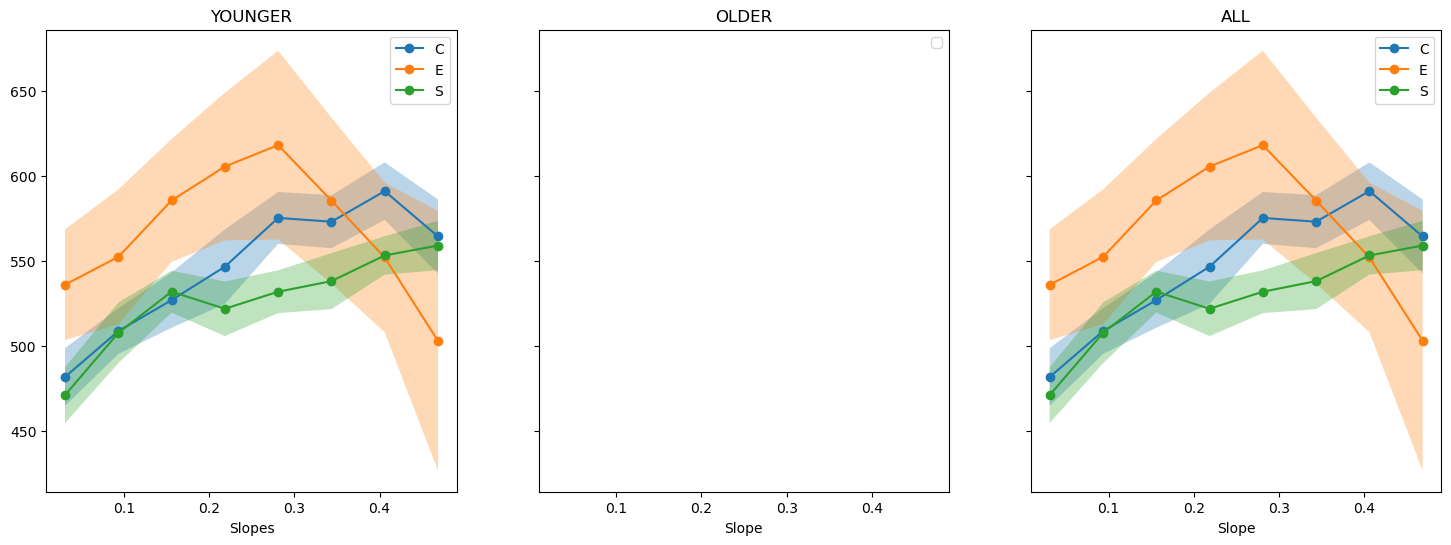

In [26]:
fig, ax = plt.subplots(1, 3, figsize = (18, 6), sharex = 'all', sharey = 'all')

# Plot the individual curves for each name
mdf_o["time_rel_c"] = mdf_o["time_rel"].apply(lambda x: x.mid)
mdf_y["time_rel_c"] = mdf_y["time_rel"].apply(lambda x: x.mid)
mean_data_F["time_rel_c"] = mean_data_F["time_rel"].apply(lambda x: x.mid)
time_intervals = mdf_y['time_rel_c'].unique()

#YOUNGER
ax[0].set_title('YOUNGER')
for name, group in mdf_y.groupby('Group'):
    ax[0].plot(time_intervals, group['mean'], marker='o', label=name)
    ax[0].fill_between(time_intervals, group['mean'] - group['sem'],
                     group['mean'] + group['sem'], alpha=0.3)

ax[0].set_xlabel('Time')
ax[0].set_xlabel('Slopes')
ax[0].legend()

#OLDER
ax[1].set_title('OLDER')
for name, group in mdf_o.groupby('Group'):
    ax[1].plot(time_intervals, group['mean'], marker='o', label=name)
    ax[1].fill_between(time_intervals, group['mean'] - group['sem'],
                     group['mean'] + group['sem'], alpha=0.3)

ax[1].set_xlabel('Time')
ax[1].set_xlabel('Slope')
ax[1].legend()

#ALL
ax[2].set_title('ALL')
for name, group in mean_data_F.groupby('Group'):
    ax[2].plot(time_intervals, group['mean'], marker='o', label=name)
    ax[2].fill_between(time_intervals, group['mean'] - group['sem'],
                     group['mean'] + group['sem'], alpha=0.3)

ax[2].set_xlabel('Time')
ax[2].set_xlabel('Slope')
ax[2].legend()


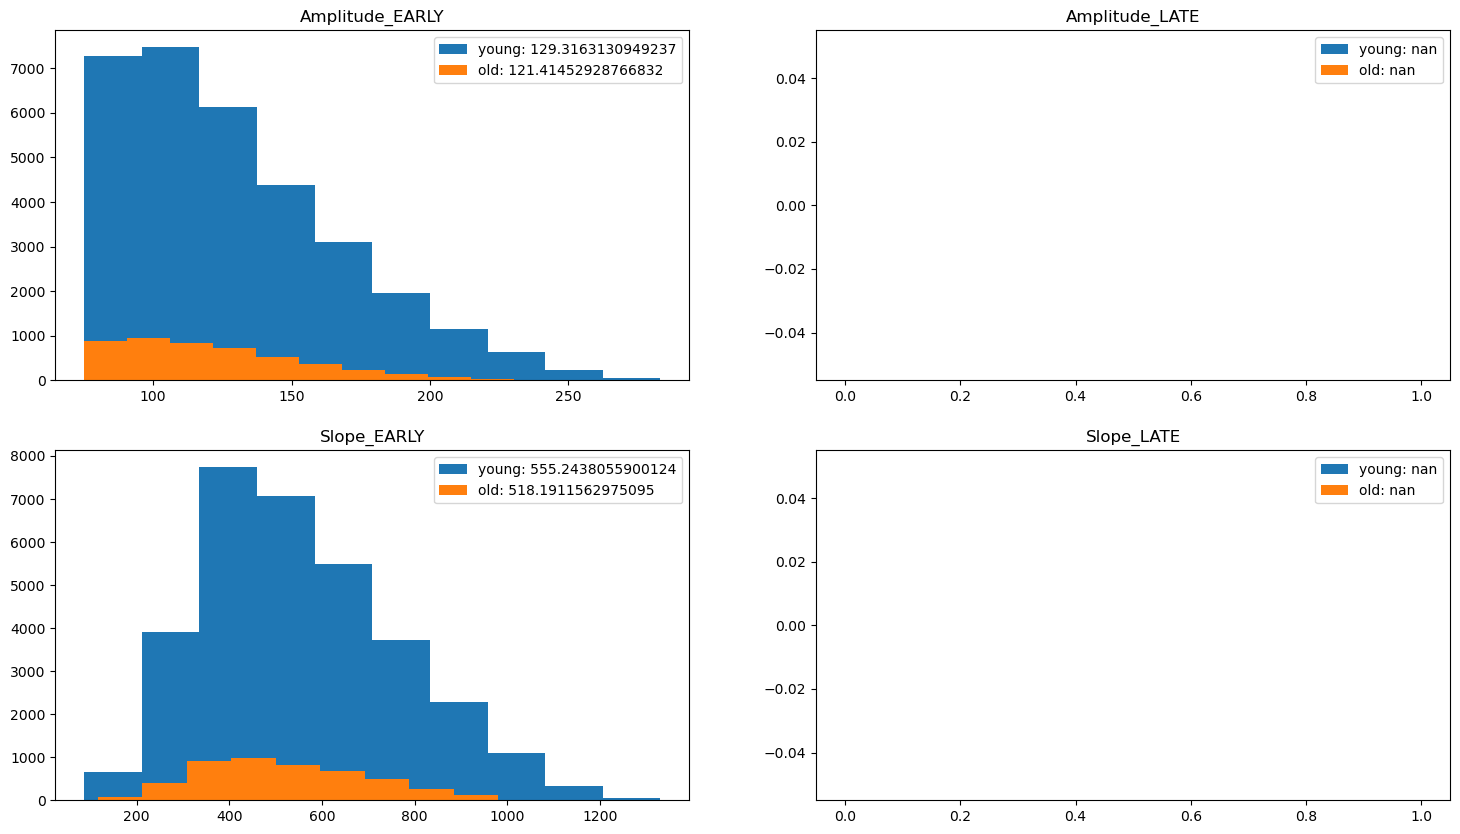

In [27]:
fig, ax = plt.subplots(2, 2, figsize = (18, 10))


data_young = data_allF[data_allF['Age'] < 20]
data_old = data_allF[data_allF['Age'] >= 20]


data_early_young = data_young[data_young['time_rel'] <= 0.3]
data_late_young = data_young[data_young['time_rel'] >= 0.5]
data_early_old = data_old[data_old['time_rel'] <= 0.3]
data_late_old = data_old[data_old['time_rel'] >= 0.5]


ax[0,0].hist(data_early_young.PTP, label = 'young: ' + str(np.mean(data_early_young.PTP)) )
ax[0,0].hist(data_early_old.PTP, label = 'old: ' + str(np.mean(data_early_old.PTP)))
ax[0,0].set_title('Amplitude_EARLY')
ax[0,0].legend()

ax[0,1].hist(data_late_young.PTP, label = 'young: ' + str(np.mean(data_late_young.PTP)) )
ax[0,1].hist(data_late_old.PTP, label = 'old: ' + str(np.mean(data_late_old.PTP)))
ax[0,1].set_title('Amplitude_LATE')
ax[0,1].legend()

ax[1,0].hist(data_early_young.Slope, label = 'young: ' + str(np.mean(data_early_young.Slope)) )
ax[1,0].hist(data_early_old.Slope, label = 'old: ' + str(np.mean(data_early_old.Slope)))
ax[1,0].set_title('Slope_EARLY')
ax[1,0].legend()

ax[1,1].hist(data_late_young.Slope, label = 'young: ' + str(np.mean(data_late_young.Slope)) )
ax[1,1].hist(data_late_old.Slope, label = 'old: ' + str(np.mean(data_late_old.Slope)))
ax[1,1].set_title('Slope_LATE')
ax[1,1].legend()


        Wave     Start  NegPeak  MidCrossing  PosPeak      End  Duration  \
23169  27470  0.406942  1465.31      1465.56  1465.79  1466.52      1.53   
23170  24755  0.406950  1465.31      1465.55  1465.76  1466.08      1.06   
23171  19170  0.406967  1465.36      1465.59  1465.81  1466.15      1.07   
23172  21871  0.409681  1475.38      1475.70  1475.95  1476.53      1.68   
23173  17166  0.409711  1475.44      1475.75  1476.00  1476.31      1.35   

       ValNegPeak  ValPosPeak         PTP       Slope  Frequency  Stage  \
23169  -52.163157   40.099641   92.262798  369.051191   0.653595      3   
23170  -95.282176   69.560831  164.843007  686.845864   0.943396      3   
23171  -64.523562   54.342547  118.866109  516.809170   0.934579      3   
23172  -75.689890   50.861905  126.551796  395.474362   0.595238      3   
23173  -47.759909   30.184742   77.944651  251.434359   0.740741      3   

      Channel  IdxChannel Group Subject Session   Age Machine ConfArousal  \
23169      F8  

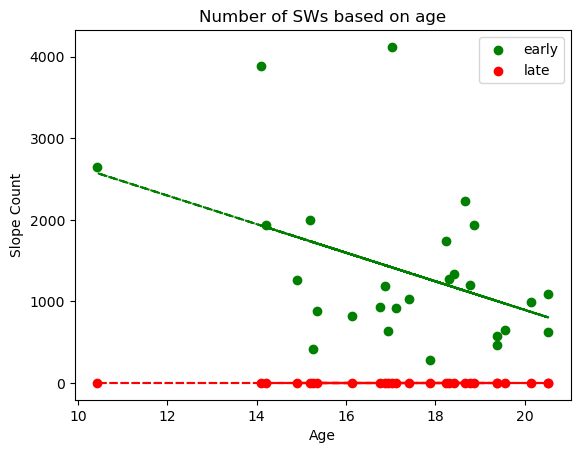

In [28]:

x_early_list = []
y_early_list = []
x_late_list = []
y_late_list = []

for name, Subject in data_allF.groupby('Subject'):
    data_early = Subject[Subject['time_rel'] <= 0.3]
    data_late = Subject[Subject['time_rel'] >= 0.5]

    print(data_early[0:5])

    x_early_list.append(Subject['Age'].unique()[0])
    y_early_list.append(data_early['Slope'].count())

    x_late_list.append(Subject['Age'].unique()[0])
    y_late_list.append(data_late['Slope'].count())

plt.scatter(x_early_list, y_early_list, marker='o', c='green', label='early')
plt.scatter(x_late_list, y_late_list, marker='o', c='red', label='late')

print(len(x_early_list))

early_fit = np.polyfit(x_early_list, y_early_list, 1)
late_fit = np.polyfit(x_late_list, y_late_list, 1)

plt.plot(x_early_list, np.polyval(early_fit, x_early_list), color='green', linestyle='--')
plt.plot(x_late_list, np.polyval(late_fit, x_late_list), color='red', linestyle='--')

plt.title('Number of SWs based on age')
plt.xlabel('Age')
plt.ylabel('Slope Count')
plt.legend()
plt.show()



# Age modelling for controls

In [29]:
bdf_c = data_allF.copy()
bdf_c = bdf_c[bdf_c['Group']=='C']
bdf_c.head()

Wave     Start  NegPeak  MidCrossing  PosPeak      End  Duration  \
23169  27470  0.406942  1465.31      1465.56  1465.79  1466.52      1.53   
23170  24755  0.406950  1465.31      1465.55  1465.76  1466.08      1.06   
23171  19170  0.406967  1465.36      1465.59  1465.81  1466.15      1.07   
23172  21871  0.409681  1475.38      1475.70  1475.95  1476.53      1.68   
23173  17166  0.409711  1475.44      1475.75  1476.00  1476.31      1.35   

       ValNegPeak  ValPosPeak         PTP       Slope  Frequency  Stage  \
23169  -52.163157   40.099641   92.262798  369.051191   0.653595      3   
23170  -95.282176   69.560831  164.843007  686.845864   0.943396      3   
23171  -64.523562   54.342547  118.866109  516.809170   0.934579      3   
23172  -75.689890   50.861905  126.551796  395.474362   0.595238      3   
23173  -47.759909   30.184742   77.944651  251.434359   0.740741      3   

      Channel  IdxChannel Group Subject Session   Age Machine ConfArousal  \
23169      F8          10     C     C06       1  14.2       O           0   
23170      F4           9     C     C06       1  14.2       O           0   
23171      F3           7     C     C06       1  14.2       O           0   
23172      Fz           8     C     C06       1  14.2       O           0   
23173      F7           6     C     C06       1  14.2       O           0   

      Position     Id  N23_times  time_rel  N3_times      diff  
23169        F  C06_1        0.4  0.000000  0.406942  0.006942  
23170        F  C06_1        0.4  0.000008  0.406942  0.006942  
23171        F  C06_1        0.4  0.000025  0.406942  0.006942  
23172        F  C06_1        0.4  0.002739  0.406942  0.006942  
23173        F  C06_1        0.4  0.002769  0.406942  0.006942

In [30]:
# Obtain first hour of SWS:

#BINS DATA FRAME _ CONTROLS

bdf_e = data_allF.copy()
bdf_e = bdf_e[bdf_e['Group']=='E']
bdf_e['time_rel'] = pd.cut(bdf_e['time_rel'], bins=8)  # Adjust the number of bins as needed
print(len(bdf_e['Id'].unique()))

bdf_e = bdf_e.groupby(['Session','Subject','time_rel'])['Slope'].mean().reset_index()
bdf_e['Group'] = bdf_e['Subject'].str[0]

age_e = age[age['Group']=='E']
#age_c = age_c[age_c['Session']==1]

bdf_e = bdf_e.merge(age_e)
bdf_e.head()


14


Session Subject           time_rel       Slope Group            Birthdate  \
0        1     E02  (-0.0005, 0.0625]  514.127810     E  2003-02-08 00:00:00   
1        1     E02    (0.0625, 0.125]  560.524167     E  2003-02-08 00:00:00   
2        1     E02     (0.125, 0.187]  601.026642     E  2003-02-08 00:00:00   
3        1     E02      (0.187, 0.25]  597.443512     E  2003-02-08 00:00:00   
4        1     E02      (0.25, 0.312]  622.476774     E  2003-02-08 00:00:00   

              Testdate M/F   Age sex  
0  2017-03-16 00:00:00   F  14.1   F  
1  2017-03-16 00:00:00   F  14.1   F  
2  2017-03-16 00:00:00   F  14.1   F  
3  2017-03-16 00:00:00   F  14.1   F  
4  2017-03-16 00:00:00   F  14.1   F

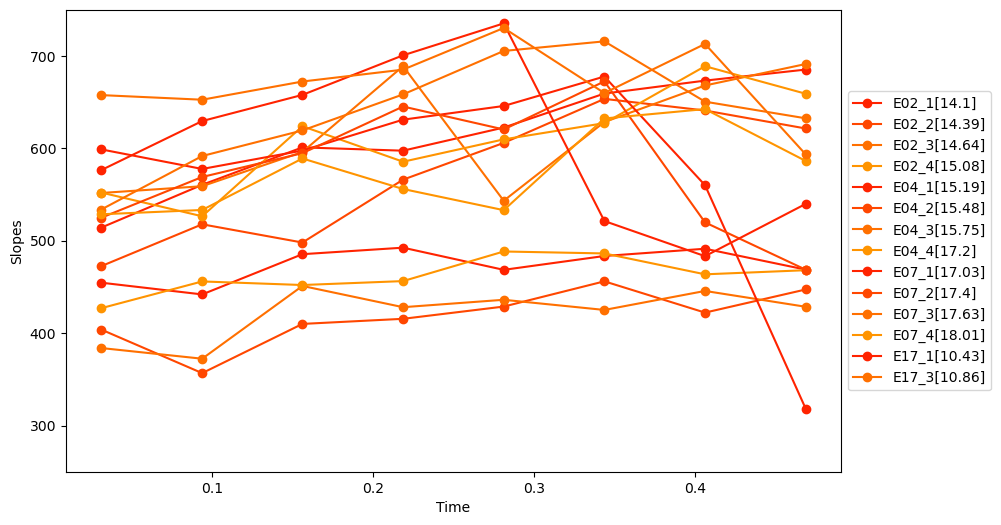

In [31]:

plt.figure(figsize=(10, 6))

# Plot the individual curves for each age

bdf_e["time_rel_c"] = bdf_e["time_rel"].apply(lambda x: x.mid).astype('object')
time_intervals = bdf_e['time_rel_c'].unique()
bdf_e['Id'] = bdf_e['Subject'] + '_' + bdf_e['Session'].astype(str)
for name, Id in bdf_e.groupby('Id'):
    plt.plot(time_intervals, Id['Slope'], marker='o', c = cm.hsv(Id['Session'].unique()[0]/40), label=str(name) + str(Id['Age'].unique()))

plt.xlabel('Time')
plt.ylabel('Slopes')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim([250,750])
plt.show()



In [32]:
# Obtain first hour of SWS:

#BINS DATA FRAME _ CONTROLS

bdf_c = data_allF.copy()
bdf_c = bdf_c[bdf_c['Group']=='C']
bdf_c['time_rel'] = pd.cut(bdf_c['time_rel'], bins=8)  # Adjust the number of bins as needed
print(len(bdf_c['Id'].unique()))

bdf_c = bdf_c.groupby(['Session','Subject','time_rel'])['Slope'].mean().reset_index()
bdf_c['Group'] = bdf_c['Subject'].str[0]

age_c = age[age['Group']=='C']
#age_c = age_c[age_c['Session']==1]

bdf_c = bdf_c.merge(age_c)
bdf_c.head()


15


Session Subject           time_rel       Slope Group            Birthdate  \
0        1     C06  (-0.0005, 0.0625]  518.232173     C  2003-04-10 00:00:00   
1        1     C06    (0.0625, 0.125]  554.215795     C  2003-04-10 00:00:00   
2        1     C06     (0.125, 0.187]  562.317153     C  2003-04-10 00:00:00   
3        1     C06      (0.187, 0.25]  577.783073     C  2003-04-10 00:00:00   
4        1     C06      (0.25, 0.312]  609.097979     C  2003-04-10 00:00:00   

              Testdate M/F   Age sex  
0  2017-06-22 00:00:00   F  14.2   F  
1  2017-06-22 00:00:00   F  14.2   F  
2  2017-06-22 00:00:00   F  14.2   F  
3  2017-06-22 00:00:00   F  14.2   F  
4  2017-06-22 00:00:00   F  14.2   F

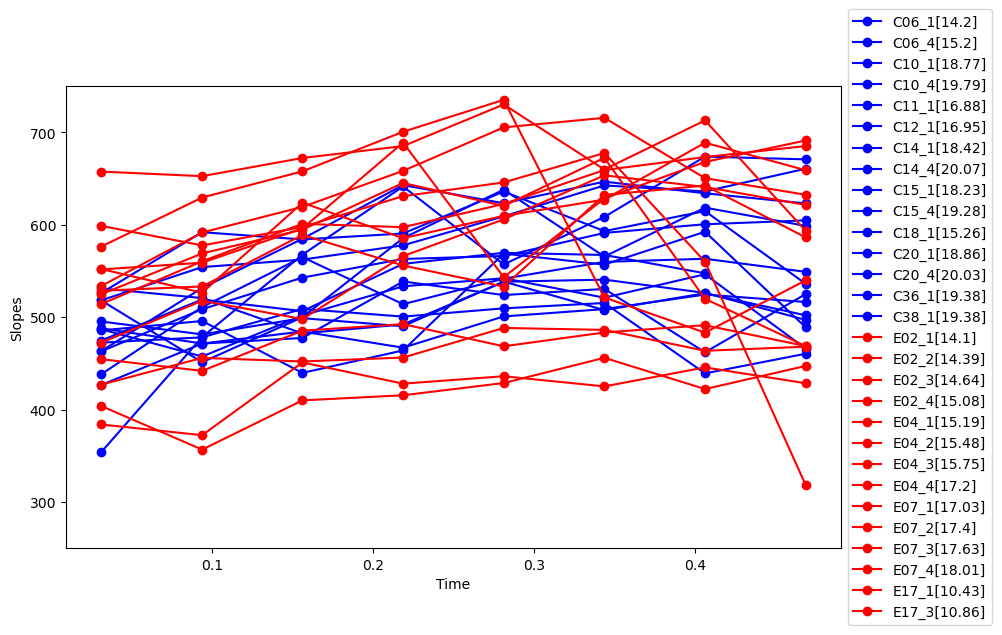

In [33]:

plt.figure(figsize=(10, 6))

# Plot the individual curves for each age

bdf_c["time_rel_c"] = bdf_c["time_rel"].apply(lambda x: x.mid).astype('object')
time_intervals = bdf_c['time_rel_c'].unique()
bdf_c['Id'] = bdf_c['Subject'] + '_' + bdf_c['Session'].astype(str)
for name, Id in bdf_c.groupby('Id'):
    plt.plot(time_intervals, Id['Slope'], marker='o', c = 'blue', label=str(name) + str(Id['Age'].unique()))

for name, Id in bdf_e.groupby('Id'):
    plt.plot(time_intervals, Id['Slope'], marker='o', c = 'red', label=str(name) + str(Id['Age'].unique()))

plt.xlabel('Time')
plt.ylabel('Slopes')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim([250,750])
plt.show()

[0.031 0.09375 0.156 0.2185 0.281 0.3435 0.406 0.4685]


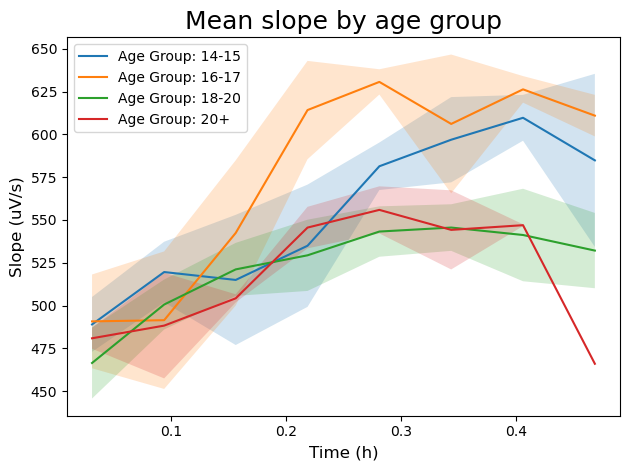

In [34]:
bins = [14, 16, 18, 20, np.inf]
labels = ['14-15','16-17','18-20', '20+']
bdf_c['age_group'] = pd.cut(bdf_c['Age'], bins=bins, labels=labels, right=False)

print(time_intervals)

for age_group, group_data in bdf_c.groupby('age_group'):
    mean_score = group_data.groupby('time_rel_c')['Slope'].mean()
    sem_score = group_data.groupby('time_rel_c')['Slope'].sem()
    plt.plot(time_intervals, mean_score.values, label=f'Age Group: {age_group}')
    plt.fill_between(mean_score.index, mean_score - sem_score, mean_score + sem_score, alpha=0.2)


plt.xlabel('Time (h)',fontsize=12)
plt.ylabel('Slope (uV/s)',fontsize=12)
plt.title('Mean slope by age group', fontsize=18)
plt.legend()
plt.tight_layout()
plt.savefig('Age_dist')
plt.show()

In [35]:
daf_c = data_allF.copy()
daf_c = daf_c[data_allF['Group']=='C']
#daf_c = daf_c[daf_c['Subject'].isin(daf_c['Subject'].value_counts()[daf_c['Subject'].value_counts() >= 20].index)]
daf_c['sAge'] = daf_c['Age']/50
print(len(daf_c['Id'].unique()))

15


[]

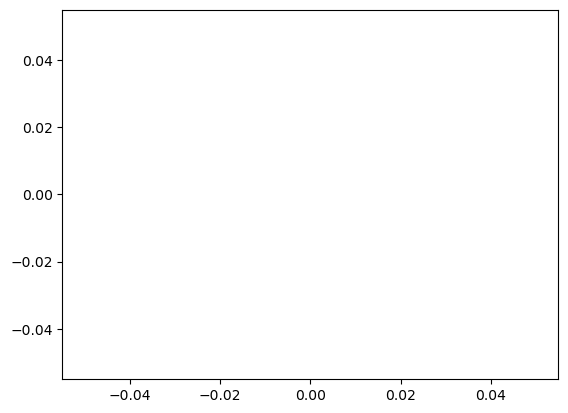

In [36]:
daf_c = data_allF.copy()
daf_c = daf_c[data_allF['Group']=='C']
daf_c = daf_c[daf_c['Id'] == 'C02_1']
plt.scatter(daf_c.time_rel,daf_c.Slope)
plt.plot()


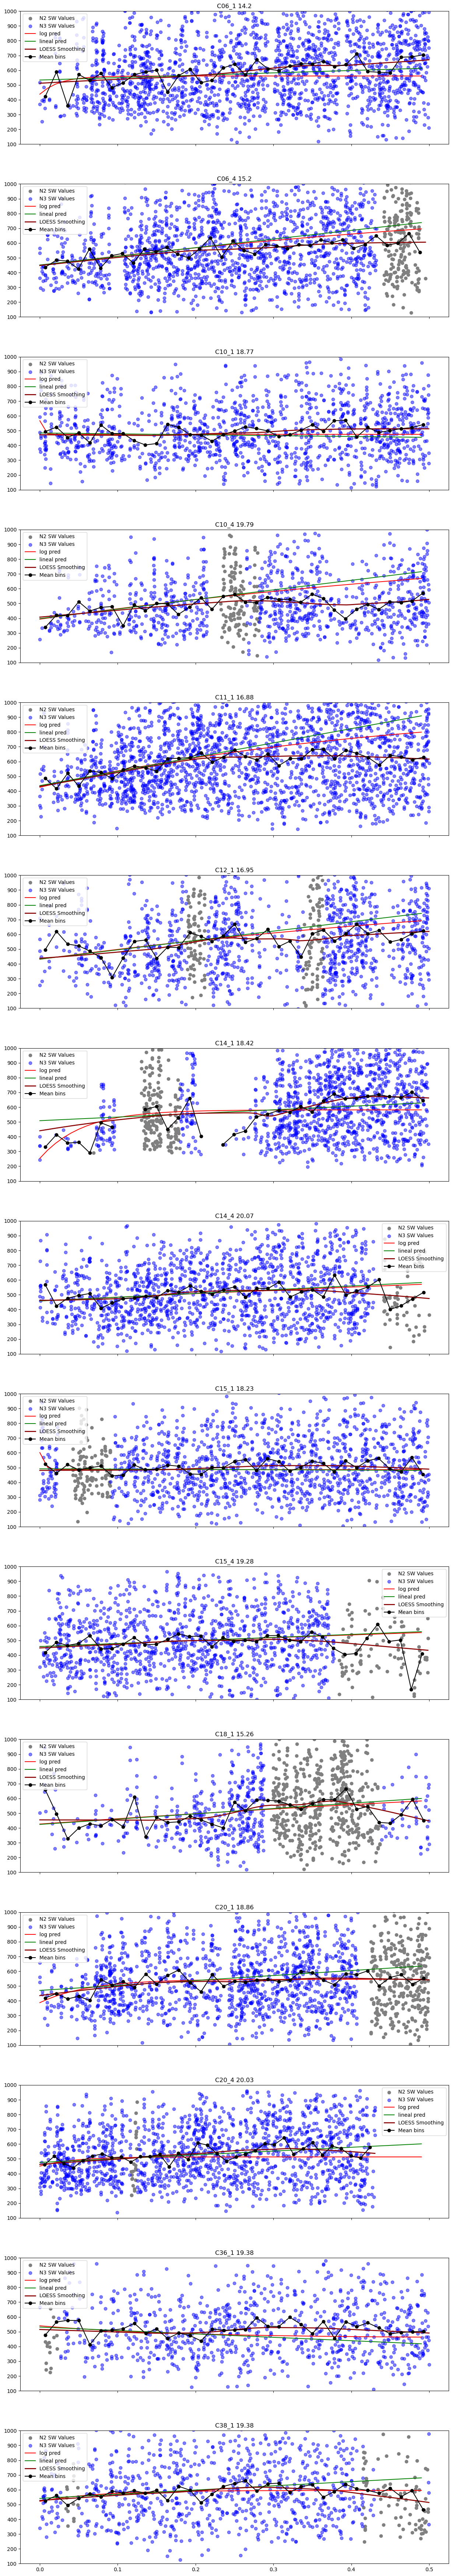

In [37]:

#LOG NO BINS
daf_c = data_allF.copy()
daf_c = daf_c[data_allF['Group']=='C']
#daf_c = daf_c[daf_c['Subject'].isin(daf_c['Subject'].value_counts()[daf_c['Subject'].value_counts() >= 20].index)]
daf_c['sAge'] = daf_c['Age']/50

def func(x, a, b, c):
    return a - (b * np.exp(-x/c))

def func_l(x, m,n):
    return m + n*x


x_list = []
a_list = []
b_list = []
c_list = []

m_list = []
n_list = []

# Get the number of subplots needed
num_subplots = len(daf_c['Id'].unique())

# Create a figure and subplots
fig, axs = plt.subplots(num_subplots, 1, figsize=(15, 6*num_subplots),sharex=True, gridspec_kw={'hspace': 0.3})

for idx, (name, Subject) in enumerate(daf_c.groupby('Id')):

    xt = Subject.time_rel.values
    x = xt[:int(len(xt)*0.40)]
    yt = Subject.Slope.values
    y = yt[:int(len(yt)*0.40)] 

    if name == 'C02_1':
        print(x)
        print(y)

    popt, pcov = curve_fit(func, x, y, bounds=([0, -1000, 0], [1000, 1000, 5]))

    coef_a = popt[0]
    coef_b = popt[1]
    coef_c = popt[2]

    x_list.append(Subject['Age'].unique()[0])
    a_list.append(coef_a)
    b_list.append(coef_b)
    c_list.append(coef_c)

    poptl, pcovl = curve_fit(func_l, x, y, bounds=([0, -1000], [1000, 1000]))

    coef_m = popt[0]
    coef_n = popt[1]


    m_list.append(coef_m)
    n_list.append(coef_n)



    # Plot on the respective subplot
    x_time = np.arange(0,0.5,0.01)
    Subject_2 = Subject[Subject['Stage']==2]
    Subject_3 = Subject[Subject['Stage']==3]
    axs[idx].scatter(Subject_2.time_rel.values, Subject_2.Slope.values,c='gray',label='N2 SW Values')
    axs[idx].scatter(Subject_3.time_rel.values, Subject_3.Slope.values,c='blue',label='N3 SW Values', alpha=0.5)
    axs[idx].plot(x_time, func(x_time, popt[0], popt[1], popt[2]), color='red', label='log pred')
    axs[idx].plot(x_time, func_l(x_time, poptl[0], poptl[1]), color='green', label='lineal pred')
    lowess = sm.nonparametric.lowess(yt,xt, frac=0.5) 
    axs[idx].plot(lowess[:, 0], lowess[:, 1], color='darkred', linewidth=2, label='LOESS Smoothing')
    axs[idx].set_title(name + ' ' + str(Subject['Age'].unique()[0]))
    bins_Subject = Subject.copy()
    bins_Subject['time_rel'] = pd.cut(bins_Subject['time_rel'], bins=35)
    bins_Subject = bins_Subject.groupby(['Session','Subject','time_rel'])['Slope'].mean().reset_index()
    bins_Subject["time_rel_c"] = bins_Subject["time_rel"].apply(lambda x: x.mid)
    time_intervals = bins_Subject['time_rel_c'].unique()
    axs[idx].plot(time_intervals, bins_Subject['Slope'], marker='o', c = 'black', label='Mean bins')
    axs[idx].set_ylim([100,1000])
    axs[idx].legend()


plt.show()
        



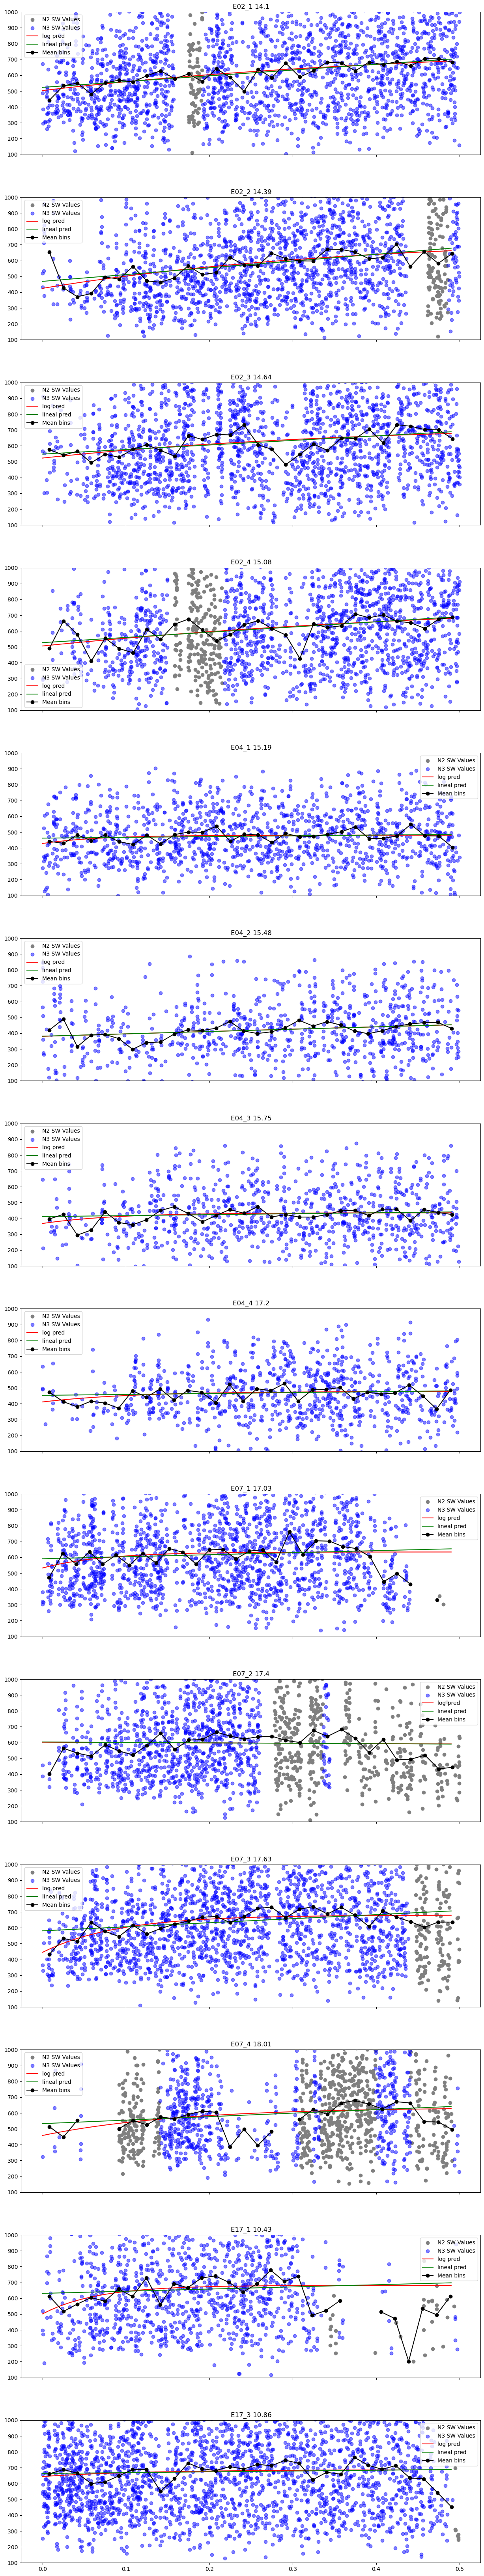

In [38]:
#LOG NO BINS
daf_e = data_allF.copy()
daf_e = daf_e[data_allF['Group']=='E']
#daf_c = daf_c[daf_c['Subject'].isin(daf_c['Subject'].value_counts()[daf_c['Subject'].value_counts() >= 20].index)]
daf_e['sAge'] = daf_e['Age']/50

def func(x, a, b, c):
    return a - (b * np.exp(-x/c))

def func_l(x, m,n):
    return m + n*x


x_list = []
a_list = []
b_list = []
c_list = []

m_list = []
n_list = []

# Get the number of subplots needed
num_subplots = len(daf_e['Id'].unique())

# Create a figure and subplots
fig, axs = plt.subplots(num_subplots, 1, figsize=(15, 6*num_subplots),sharex=True, gridspec_kw={'hspace': 0.3})

for idx, (name, Subject) in enumerate(daf_e.groupby('Id')):

    x = Subject.time_rel.values
    y = Subject.Slope.values

    if name == 'C02_1':
        print(x)
        print(y)

    popt, pcov = curve_fit(func, x, y, bounds=([0, -1000, 0], [1000, 1000, 5]))

    coef_a = popt[0]
    coef_b = popt[1]
    coef_c = popt[2]

    x_list.append(Subject['Age'].unique()[0])
    a_list.append(coef_a)
    b_list.append(coef_b)
    c_list.append(coef_c)

    poptl, pcovl = curve_fit(func_l, x, y, bounds=([0, -1000], [1000, 1000]))

    coef_m = popt[0]
    coef_n = popt[1]


    m_list.append(coef_m)
    n_list.append(coef_n)



    # Plot on the respective subplot
    x_time = np.arange(0,0.5,0.01)
    Subject_2 = Subject[Subject['Stage']==2]
    Subject_3 = Subject[Subject['Stage']==3]
    axs[idx].scatter(Subject_2.time_rel.values, Subject_2.Slope.values,c='gray',label='N2 SW Values')
    axs[idx].scatter(Subject_3.time_rel.values, Subject_3.Slope.values,c='blue',label='N3 SW Values', alpha=0.5)
    axs[idx].plot(x_time, func(x_time, popt[0], popt[1], popt[2]), color='red', label='log pred')
    axs[idx].plot(x_time, func_l(x_time, poptl[0], poptl[1]), color='green', label='lineal pred')
    axs[idx].set_title(name + ' ' + str(Subject['Age'].unique()[0]))
    bins_Subject = Subject.copy()
    bins_Subject['time_rel'] = pd.cut(bins_Subject['time_rel'], bins=30)
    bins_Subject = bins_Subject.groupby(['Session','Subject','time_rel'])['Slope'].mean().reset_index()
    bins_Subject["time_rel_c"] = bins_Subject["time_rel"].apply(lambda x: x.mid)
    time_intervals = bins_Subject['time_rel_c'].unique()
    axs[idx].plot(time_intervals, bins_Subject['Slope'], marker='o', c = 'black', label='Mean bins')
    axs[idx].set_ylim([100,1000])
    axs[idx].legend()


plt.show()

In [39]:
Subject.head()

Wave     Start  NegPeak  MidCrossing  PosPeak    End  Duration  \
456603  18501  0.008408    30.46        30.65    30.84  31.00      0.73   
456604  15613  0.008578    31.17        31.53    31.86  32.12      1.24   
456605  18502  0.008611    31.28        31.54    31.77  32.04      1.04   
456606  21498  0.008617    31.29        31.52    31.76  32.01      0.99   
456607  18503  0.008900    32.75        32.93    33.16  33.35      1.31   

        ValNegPeak  ValPosPeak         PTP       Slope  Frequency  Stage  \
456603  -52.466519   49.390506  101.857025  536.089607   1.369863      3   
456604  -47.474239   43.890883   91.365121  253.792004   0.806452      3   
456605  -98.501852   72.451881  170.953733  657.514357   0.961538      3   
456606  -69.209107   67.609918  136.819025  594.865326   1.010101      3   
456607  -49.826996   75.998868  125.825864  699.032579   0.763359      3   

       Channel  IdxChannel Group Subject Session    Age Machine ConfArousal  \
456603      Fz           8     E     E17       3  10.86       N           0   
456604      F3           7     E     E17       3  10.86       N           0   
456605      Fz           8     E     E17       3  10.86       N           0   
456606      F4           9     E     E17       3  10.86       N           0   
456607      Fz           8     E     E17       3  10.86       N           0   

       Position     Id  N23_times  time_rel  N3_times      diff    sAge  
456603        F  E17_3        0.0  0.000000  0.008408  0.008408  0.2172  
456604        F  E17_3        0.0  0.000169  0.008408  0.008408  0.2172  
456605        F  E17_3        0.0  0.000203  0.008408  0.008408  0.2172  
456606        F  E17_3        0.0  0.000208  0.008408  0.008408  0.2172  
456607        F  E17_3        0.0  0.000492  0.008408  0.008408  0.2172

 _____________ Fitted Parameters So:
M: 494.12145264002197
N: -0.02564230760581998
 _____________ Fitted Parameters St:
a: -9999.999978672931
b: -10899.97977762844
c: 268.30799433434356
[[ 1.92439117e+12  1.92027234e+12 -5.05241892e+10]
 [ 1.92027234e+12  1.91616241e+12 -5.04160226e+10]
 [-5.05241892e+10 -5.04160226e+10  1.32650457e+09]]


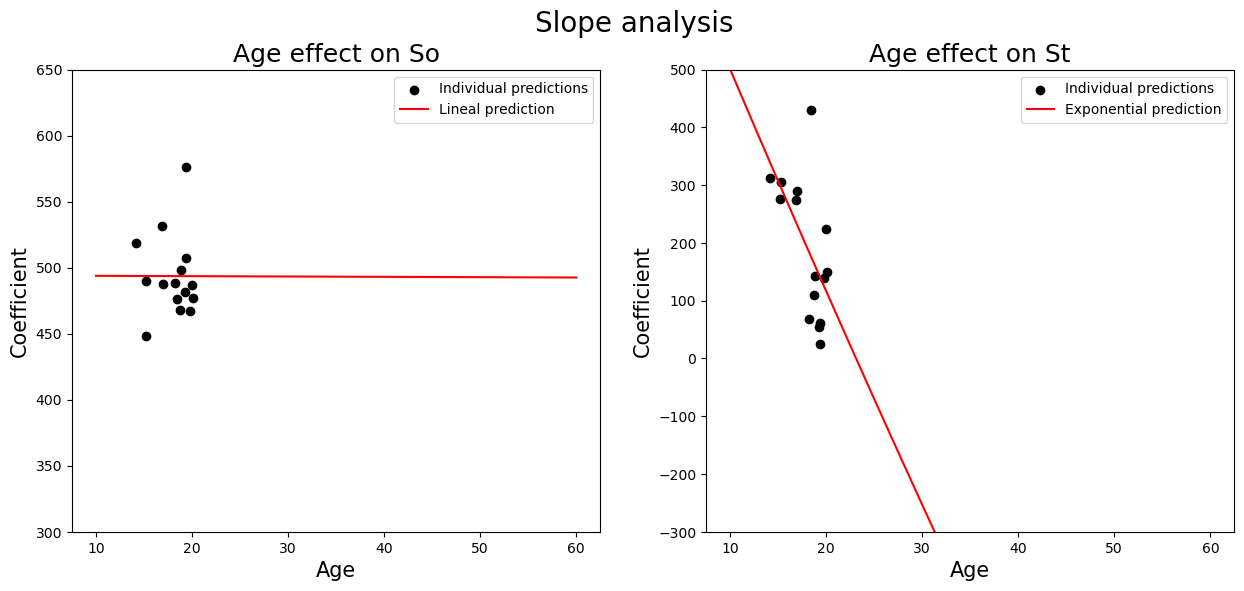

In [40]:
#LOG NO BINS


daf_c = data_allF[data_allF['Group']=='C']


#CONTROL SWA found

daf_c = daf_c[daf_c['Subject'].isin(daf_c['Subject'].value_counts()[daf_c['Subject'].value_counts() >= 20].index)]


daf_c['sAge'] = daf_c['Age']/50


def func_l(x, m, n):
    return m + n*x

def func_exp(x, a, b, c):
    return a  - (b * np.exp(-x/c))


x_list = []
m_list = []
n_list = []


for name, Subject in daf_c.groupby('Id'):
    #plt.scatter(Subject.time_rel.values,Subject.Slope.values)
    x = Subject.time_rel.values
    #x = x[0:(int(len(x)*0.3))]
    y = Subject.Slope.values
    #y = y[0:(int(len(y)*0.3))]
    popt, pcov = curve_fit(func_l, x, y,bounds=([0,-1000],[1000,1000]))

    #plt.plot(x, func(x,popt[0],popt[1],popt[2]))
    coef_m = popt[0]
    coef_n = popt[1]

    x_list.append(Subject['Age'].unique()[0])
    m_list.append(coef_m)
    n_list.append(coef_n)

fig, ax = plt.subplots(1, 2, figsize = (15, 6))

splot = 0
coef_names = ['So','St']
total_coefs = []

for coef_list in [m_list,n_list]:
    y_list = coef_list

    sorted_data = sorted(zip(x_list, y_list))
    x_sorted, y_sorted = zip(*sorted_data)
    x_sorted = np.array(x_sorted)
    y_sorted = np.array(y_sorted)

    if splot == 0:
        
        popt_t, pcov_t = curve_fit(func_l, x_sorted, y_sorted,bounds=([0,-1000],[1000,1000]))

        print(" _____________ Fitted Parameters " + coef_names[splot]+":")
        print("M:", popt_t[0])
        print("N:", popt_t[1])

        total_coefs.append(popt_t[0])
        total_coefs.append(popt_t[1])


        x_ages = np.linspace(10,60,200)

        ax[splot].scatter(x_sorted, y_sorted, marker='o', c='black', label='Individual predictions')
        ax[splot].plot(x_ages, func_l(x_ages, popt_t[0], popt_t[1]), c='red', label='Lineal prediction')

    else: 
        popt_t, pcov_t,info, mesg,ier= curve_fit(func_exp, x_sorted, y_sorted, bounds=([-10000, -15000, 0], [10000, 0, 1000]), full_output=True)


        print(" _____________ Fitted Parameters " + coef_names[splot]+":")
        print("a:", popt_t[0])
        print("b:", popt_t[1])
        print("c:", popt_t[2])
        print(pcov_t)

        total_coefs.append(popt_t[0])
        total_coefs.append(popt_t[1])
        total_coefs.append(popt_t[2])
    

        x_ages = np.linspace(10,60,200)

        ax[splot].scatter(x_sorted, y_sorted, marker='o', c='black', label='Individual predictions')
        ax[splot].plot(x_ages, func_exp(x_ages, popt_t[0], popt_t[1], popt_t[2]), c='red', label='Exponential prediction')

    ax[splot].set_title('Age effect on ' + coef_names[splot],fontsize=18)
    ax[splot].set_xlabel('Age',fontsize=15)
    ax[splot].set_ylabel('Coefficient',fontsize=15)


    if splot == 0:
        ax[splot].set_ylim([300,650])
    else:
        ax[splot].set_ylim([-300,500])

    ax[splot].legend()


    splot = splot + 1


fig.suptitle("Slope analysis", fontsize=20)
plt.savefig('Age model', bbox_inches='tight')
plt.show()



In [41]:
print(total_coefs)

[494.12145264002197, -0.02564230760581998, -9999.999978672931, -10899.97977762844, 268.30799433434356]


In [42]:
age

Subject  Session            Birthdate             Testdate  M/F    Age  \
0       C02        1  1994-05-28 00:00:00  2017-04-26 00:00:00    F  22.91   
1       C03        1  1988-09-09 00:00:00  2017-05-18 00:00:00    F  28.69   
2       C04        1  1987-05-24 00:00:00  2017-06-08 00:00:00    F  30.04   
3       C06        1  2003-04-10 00:00:00  2017-06-22 00:00:00    F  14.20   
4       C07        1  1994-06-05 00:00:00  2017-07-05 00:00:00    F  23.08   
..      ...      ...                  ...                  ...  ...    ...   
160     S07        4  2002-06-21 00:00:00  2019-03-28 00:00:00  NaN  16.77   
161     S08        4  2003-05-09 00:00:00  2019-03-27 00:00:00  NaN  15.88   
162     S11        4  2003-05-15 00:00:00  2019-11-07 00:00:00  NaN  16.48   
163     S12        4  1998-03-04 00:00:00  2019-09-05 00:00:00  NaN  21.51   
164     S15        4  2000-06-18 00:00:00  2020-02-20 00:00:00  NaN  19.67   

    Group  sex  
0       C    F  
1       C    F  
2       C    F  
3       C    F  
4       C    F  
..    ...  ...  
160     S  NaN  
161     S    F  
162     S    M  
163     S    F  
164     S    F  

[165 rows x 8 columns]

36822


[]

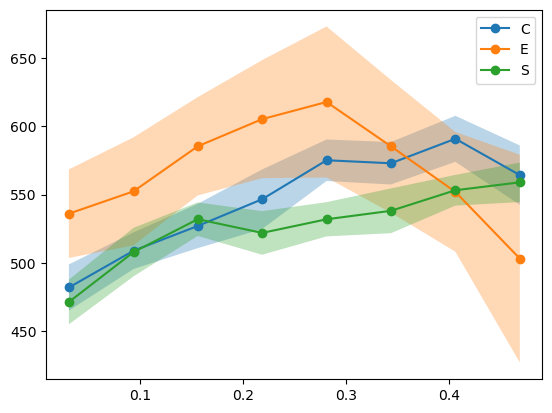

In [43]:
bins_data_F = data_allF.copy()
bins_data_F = bins_data_F[bins_data_F['Age']<22]
bins_data_F = bins_data_F[bins_data_F['Session']==1]
bins_data_F['time_rel'] = pd.cut(bins_data_F['time_rel'], bins=8)  
print (len(bins_data_F))

bdf = bins_data_F.groupby(['Session','Subject','time_rel'])['Slope'].mean().reset_index()
bdf['Group'] = bdf['Subject'].str[0]
bdf["time_rel_c"] = bdf["time_rel"].apply(lambda x: x.mid)
time_intervals = bdf['time_rel_c'].unique()
age_1 = age[age['Session']==1]
bdf = bdf.merge(age)

mdf = bdf.groupby(['Group','time_rel'])['Slope'].agg(['mean', 'sem']).reset_index()


for name, group in mdf.groupby('Group'):
    plt.plot(time_intervals, group['mean'], marker='o', label=name)
    plt.fill_between(time_intervals, group['mean'] - group['sem'],
                     group['mean'] + group['sem'], alpha=0.3)
plt.legend()
plt.plot()



36822


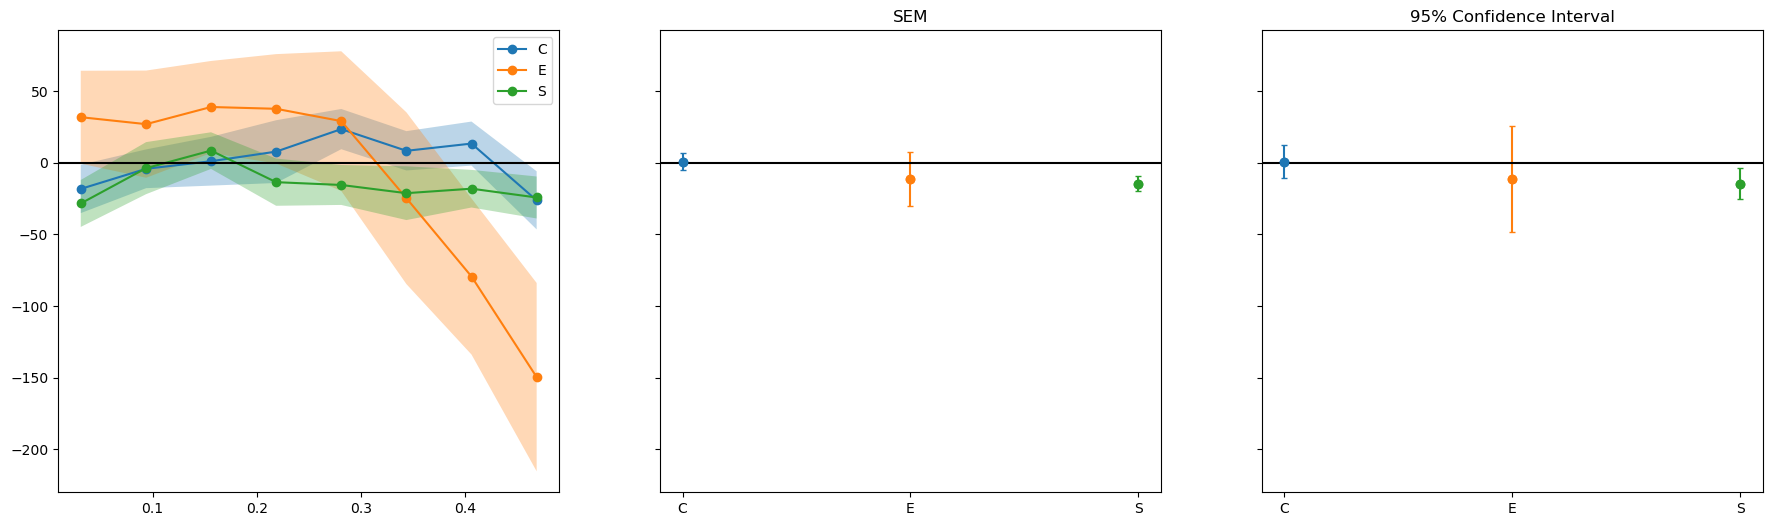

In [44]:
bins_data_F = data_allF.copy()
#bins_data_F = bins_data_F[(bins_data_F['Session'] == 1) | ((bins_data_F['Group'] == 'E') & (bins_data_F['Session'] == 2))]
bins_data_F = bins_data_F[bins_data_F['Session'] == 1]
bins_data_F['time_rel'] = pd.cut(bins_data_F['time_rel'], bins=8)  
print (len(bins_data_F))

bdf = bins_data_F.groupby(['Session','Subject','time_rel'])['Slope'].mean().reset_index()
bdf['Group'] = bdf['Subject'].str[0]
bdf["time_rel_c"] = bdf["time_rel"].apply(lambda x: x.mid)
time_intervals = bdf['time_rel_c'].unique()
age_1 = age[age['Session']==1]
bdf = bdf.merge(age)

bdf['Age'] = pd.to_numeric(bdf['Age'], errors='coerce')
bdf['time_rel_c'] = pd.to_numeric(bdf['time_rel_c'], errors='coerce')

bdf['Slope_n'] = (
    total_coefs[0] +
    total_coefs[1] * bdf['Age'] +
    (total_coefs[2] - total_coefs[3] * np.exp(-bdf['Age'] / total_coefs[4])) * bdf['time_rel_c']
)

bdf['Slope_rel'] = bdf['Slope'] - bdf['Slope_n']

mdf = bdf.groupby(['Group', 'time_rel'])['Slope_rel'].agg(['mean', 'sem']).reset_index()
mdf_t = bdf.groupby(['Group'])['Slope_rel'].agg(['mean', 'sem']).reset_index()

# Plotting
fig, ax = plt.subplots(1, 3, figsize = (22, 6),sharey=True)
for name, group in mdf.groupby('Group'):
    ax[0].plot(time_intervals, group['mean'], marker='o', label=name)
    if name == 'C':
        diff_c = group['mean']
    if name == 'E':
        diff_e = group['mean']
    if name == 'S':
        diff_s = group['mean']


    ax[0].fill_between(time_intervals, group['mean'] - group['sem'],
                     group['mean'] + group['sem'], alpha=0.3)

ax[0].axhline(0, color='black')
ax[0].legend()

for name, group in mdf_t.groupby('Group'):
    ax[1].scatter(name,group['mean'])
    ax[1].errorbar(name, group['mean'], yerr=group['sem'],capsize=2, marker="o")
ax[1].axhline(0, color='black')
ax[1].set_title('SEM')

for name, group in mdf_t.groupby('Group'):
    ax[2].scatter(name,group['mean'])
    ax[2].errorbar(name, group['mean'], yerr=group['sem']*1.96,capsize=2, marker="o")
ax[2].axhline(0, color='black')
ax[2].set_title('95% Confidence Interval')
plt.show()


In [45]:
time_intervals.astype(float)

array([0.031  , 0.09375, 0.156  , 0.2185 , 0.281  , 0.3435 , 0.406  ,
       0.4685 ])

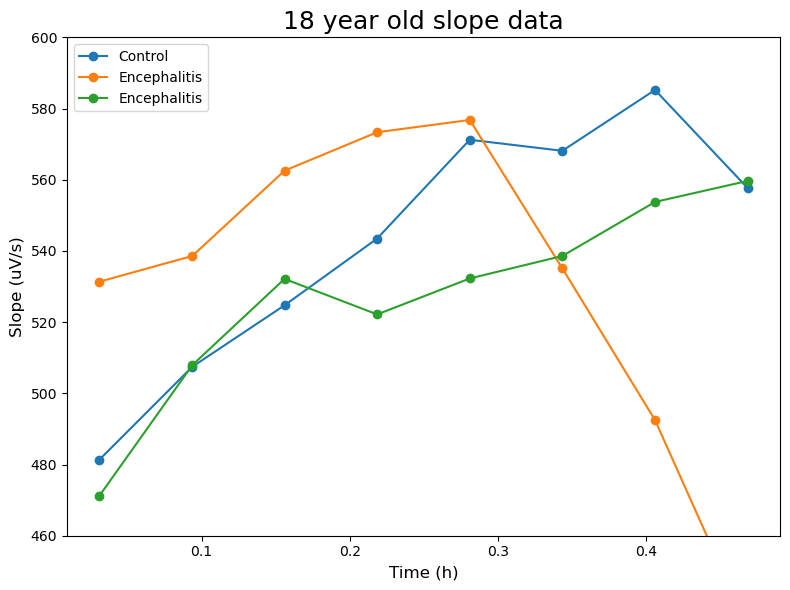

In [46]:
age_y = 18
age_o = 50
time_intervals

Slope_pred_y = total_coefs[0] + total_coefs[1] * age_y + (total_coefs[2] - total_coefs[3] * np.exp(-age_y/ total_coefs[4])) * time_intervals.astype(float)
Slope_pred_cy = Slope_pred_y + diff_c
Slope_pred_ey = Slope_pred_y + diff_e
Slope_pred_sy = Slope_pred_y + diff_s

Slope_pred_o = total_coefs[0] + total_coefs[1] * age_o + (total_coefs[2] - total_coefs[3] * np.exp(-age_o/ total_coefs[4])) * time_intervals.astype(float)
Slope_pred_co = Slope_pred_o + diff_c
Slope_pred_eo = Slope_pred_o + diff_e
Slope_pred_so = Slope_pred_y + diff_s

plt.figure(figsize=(8, 6))


plt.plot(time_intervals, Slope_pred_cy,marker='o', label = 'Control')
plt.plot(time_intervals, Slope_pred_ey,marker='o', label = 'Encephalitis')
plt.plot(time_intervals, Slope_pred_sy,marker='o', label = 'Encephalitis')
plt.ylim([460,600])
plt.xlabel('Time (h)',fontsize=12)
plt.ylabel('Slope (uV/s)',fontsize=12)
plt.title('18 year old slope data', fontsize=18)
plt.legend()
plt.tight_layout()
plt.savefig('y_sim.png')

plt.show()





40874


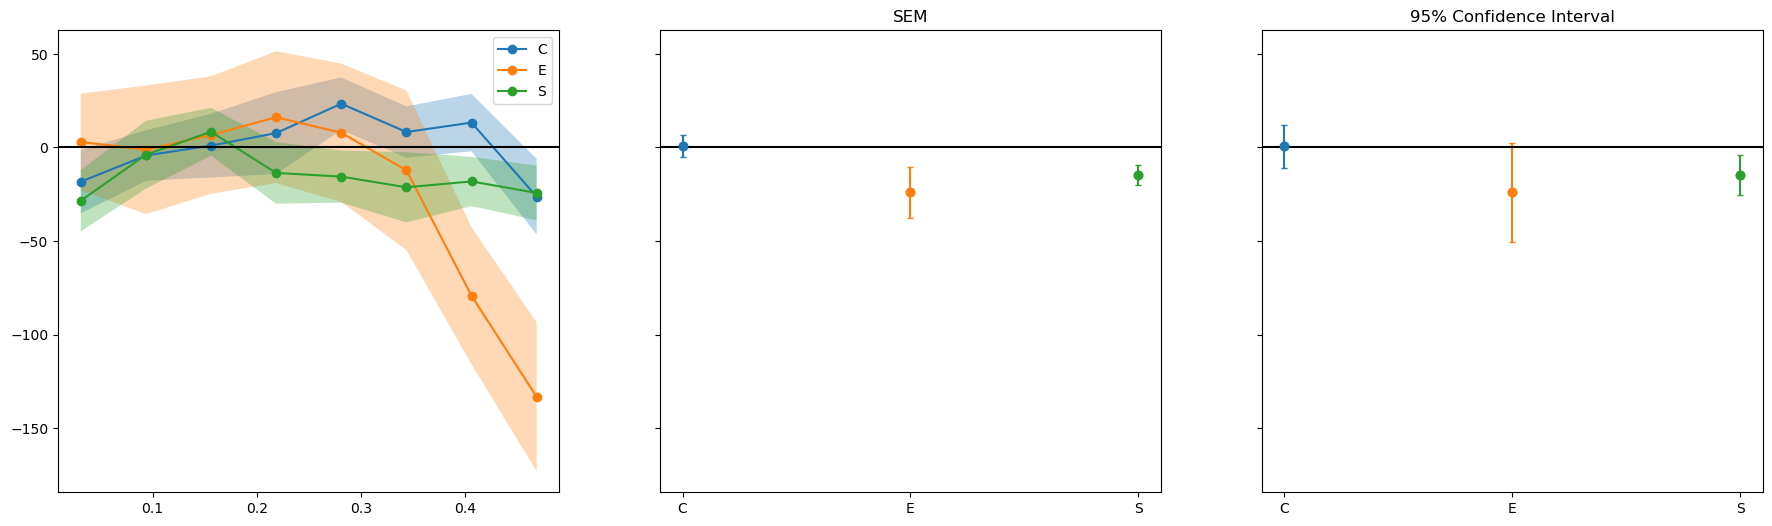

In [47]:
bins_data_F = data_allF.copy()
bins_data_F = bins_data_F[(bins_data_F['Session'] == 1) | ((bins_data_F['Group'] == 'E') & (bins_data_F['Session'] == 2))]
#bins_data_F = bins_data_F[bins_data_F['Session'] == 1]
bins_data_F['time_rel'] = pd.cut(bins_data_F['time_rel'], bins=8)  
print (len(bins_data_F))

bdf = bins_data_F.groupby(['Session','Subject','time_rel'])['Slope'].mean().reset_index()
bdf['Group'] = bdf['Subject'].str[0]
bdf["time_rel_c"] = bdf["time_rel"].apply(lambda x: x.mid)
time_intervals = bdf['time_rel_c'].unique()
age_1 = age[age['Session']==1]
bdf = bdf.merge(age)

bdf['Age'] = pd.to_numeric(bdf['Age'], errors='coerce')
bdf['time_rel_c'] = pd.to_numeric(bdf['time_rel_c'], errors='coerce')

bdf['Slope_n'] = (
    total_coefs[0] +
    total_coefs[1] * bdf['Age'] +
    (total_coefs[2] - total_coefs[3] * np.exp(-bdf['Age'] / total_coefs[4])) * bdf['time_rel_c']
)

bdf['Slope_rel'] = bdf['Slope'] - bdf['Slope_n']

mdf = bdf.groupby(['Group', 'time_rel'])['Slope_rel'].agg(['mean', 'sem']).reset_index()
mdf_t = bdf.groupby(['Group'])['Slope_rel'].agg(['mean', 'sem']).reset_index()

# Plotting
fig, ax = plt.subplots(1, 3, figsize = (22, 6),sharey=True)
for name, group in mdf.groupby('Group'):
    ax[0].plot(time_intervals, group['mean'], marker='o', label=name)
    if name == 'C':
        diff_c = group['mean']
    if name == 'E':
        diff_e = group['mean']
    if name == 'S':
        diff_s = group['mean']


    ax[0].fill_between(time_intervals, group['mean'] - group['sem'],
                     group['mean'] + group['sem'], alpha=0.3)

ax[0].axhline(0, color='black')
ax[0].legend()

for name, group in mdf_t.groupby('Group'):
    ax[1].scatter(name,group['mean'])
    ax[1].errorbar(name, group['mean'], yerr=group['sem'],capsize=2, marker="o")
ax[1].axhline(0, color='black')
ax[1].set_title('SEM')

for name, group in mdf_t.groupby('Group'):
    ax[2].scatter(name,group['mean'])
    ax[2].errorbar(name, group['mean'], yerr=group['sem']*1.96,capsize=2, marker="o")
ax[2].axhline(0, color='black')
ax[2].set_title('95% Confidence Interval')
plt.show()


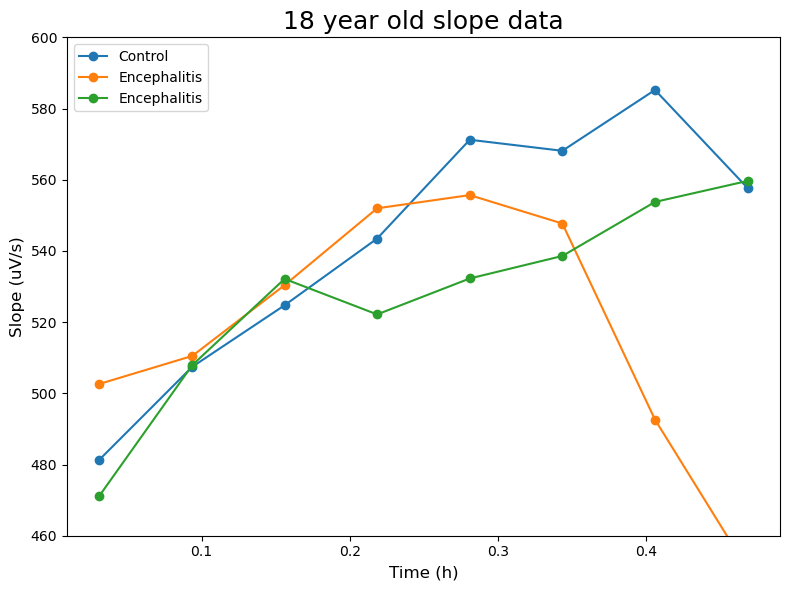

In [48]:
age_y = 18
age_o = 50
time_intervals

Slope_pred_y = total_coefs[0] + total_coefs[1] * age_y + (total_coefs[2] - total_coefs[3] * np.exp(-age_y/ total_coefs[4])) * time_intervals.astype(float)
Slope_pred_cy = Slope_pred_y + diff_c
Slope_pred_ey = Slope_pred_y + diff_e
Slope_pred_sy = Slope_pred_y + diff_s

Slope_pred_o = total_coefs[0] + total_coefs[1] * age_o + (total_coefs[2] - total_coefs[3] * np.exp(-age_o/ total_coefs[4])) * time_intervals.astype(float)
Slope_pred_co = Slope_pred_o + diff_c
Slope_pred_eo = Slope_pred_o + diff_e
Slope_pred_so = Slope_pred_y + diff_s

plt.figure(figsize=(8, 6))


plt.plot(time_intervals, Slope_pred_cy,marker='o', label = 'Control')
plt.plot(time_intervals, Slope_pred_ey,marker='o', label = 'Encephalitis')
plt.plot(time_intervals, Slope_pred_sy,marker='o', label = 'Encephalitis')
plt.ylim([460,600])
plt.xlabel('Time (h)',fontsize=12)
plt.ylabel('Slope (uV/s)',fontsize=12)
plt.title('18 year old slope data', fontsize=18)
plt.legend()
plt.tight_layout()
plt.savefig('y_sim.png')

plt.show()

In [49]:
model = Lmer('Slope_rel ~ time_rel_c*Age*Group + (1|Subject)', data=bdf)
model.fit()



print(model.coefs)

/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "time_rel". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "Birthdate". Fall back to string conversion. The error is: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
  warnings.warn('Error while trying to convert '
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "Testdate". Fall back to string conversion. The error is: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
  warnings.warn('Error while trying to convert '


Linear mixed model fit by REML [’lmerMod’]
Formula: Slope_rel~time_rel_c*Age*Group+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 232	 Groups: {'Subject': 26.0}

Log-likelihood: -1206.909 	 AIC: 2441.818

Random effects:

                 Name       Var     Std
Subject   (Intercept)  2001.195  44.735
Residual               2389.160  48.879

No random effect correlations specified

Fixed effects:

                         Estimate       2.5_ci     97.5_ci          SE  \
(Intercept)            -37.025894  -406.520437  332.468650  188.521088   
time_rel_c             -21.998688  -809.326371  765.328995  401.705179   
Age                      1.946698   -18.913208   22.806604   10.643005   
GroupE                 262.760464  -219.271681  744.792609  245.939287   
GroupS                  -8.536823  -492.484611  475.410966  246.916674   
time_rel_c:Age           1.998634   -42.450146   46.447413   22.678365   
time_rel_c:GroupE     -742.059102 -1748.619290  264

In [50]:
# DATA

# x is a matrix one column per participant, one row per time  70 * 8
# age is a vector of 70 * 1 values
# group is a matrix of one column per participant, 70 * 3 rows (is_control, is_enc, is_sq)

# X is a matrix with all data above:  70 * 12(8+1+3) 

# PARAMETERS
# mi is a vector of 70 values
# mage is a scalar
# mgroup is a vector of 3 values (control, enc, sq)


# Y = 8*70



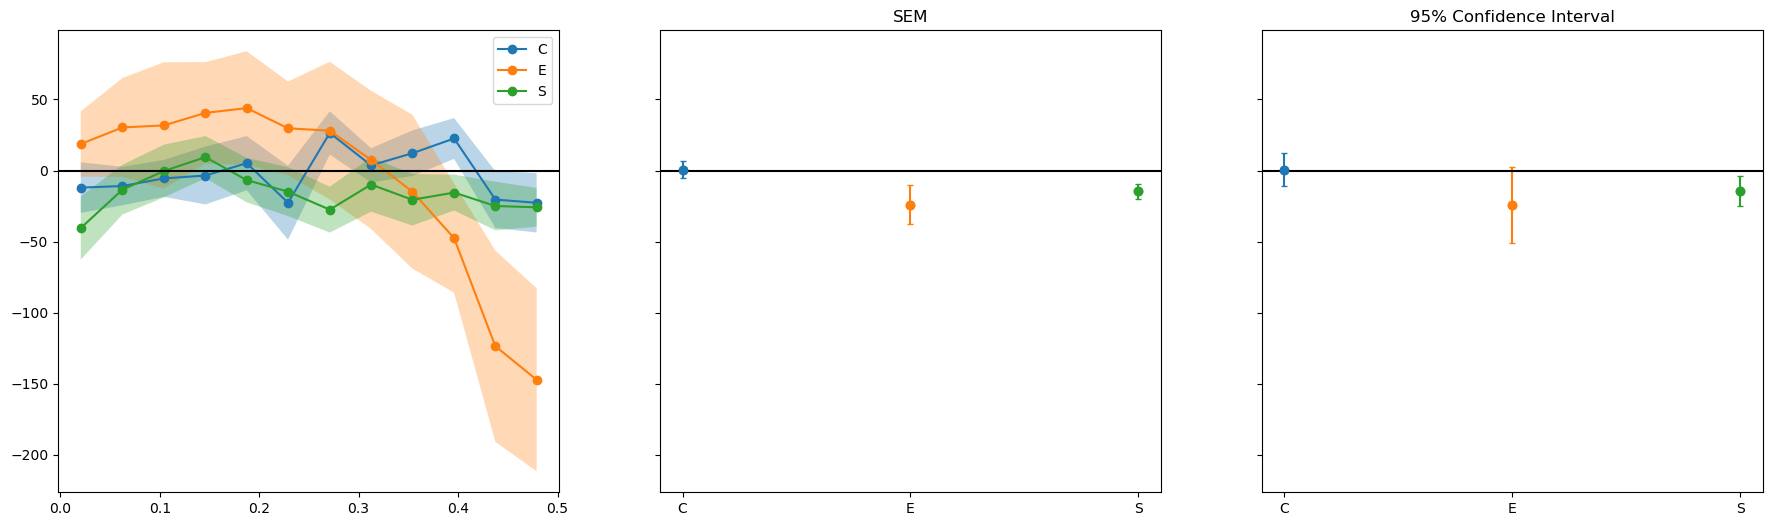

In [51]:
daf = data_allF.copy()
daf = daf[daf['Session']==1]
daf['Slope_n'] = (
    total_coefs[0] +
    total_coefs[1] * daf['Age'] +
    (total_coefs[2] - total_coefs[3] * np.exp(-daf['Age'] / total_coefs[4])) * daf['time_rel']
)

daf['Slope_rel'] = daf['Slope'] - daf['Slope_n']
bdaf = daf.copy()
bdaf['time_rel'] = pd.cut(bdaf['time_rel'], bins=12)  
bdaf = bdaf.groupby(['Session','Subject','time_rel'])['Slope_rel'].mean().reset_index()
bdaf['Group'] = bdaf['Subject'].str[0]
bdaf["time_rel_c"] = bdaf["time_rel"].apply(lambda x: x.mid)
time_intervals = bdaf['time_rel_c'].unique()
age_1 = age[age['Session']==1]
bdaf = bdaf.merge(age)

bdaf['Age'] = pd.to_numeric(bdaf['Age'], errors='coerce')
bdaf['time_rel_c'] = pd.to_numeric(bdaf['time_rel_c'], errors='coerce')

mdaf = bdaf.groupby(['Group', 'time_rel'])['Slope_rel'].agg(['mean', 'sem']).reset_index()

# Plotting
fig, ax = plt.subplots(1, 3, figsize = (22, 6),sharey=True)
for name, group in mdaf.groupby('Group'):
    ax[0].plot(time_intervals, group['mean'], marker='o', label=name)
    ax[0].fill_between(time_intervals, group['mean'] - group['sem'],
                     group['mean'] + group['sem'], alpha=0.3)

ax[0].axhline(0, color='black')
ax[0].legend()

for name, group in mdf_t.groupby('Group'):
    ax[1].scatter(name,group['mean'])
    ax[1].errorbar(name, group['mean'], yerr=group['sem'],capsize=2, marker="o")
ax[1].axhline(0, color='black')
ax[1].set_title('SEM')

for name, group in mdf_t.groupby('Group'):
    ax[2].scatter(name,group['mean'])
    ax[2].errorbar(name, group['mean'], yerr=group['sem']*1.96,capsize=2, marker="o")
ax[2].axhline(0, color='black')
ax[2].set_title('95% Confidence Interval')
plt.show()


In [52]:
mdaf.head()


Group           time_rel       mean        sem
0     C  (-0.0005, 0.0417] -11.999807  17.771262
1     C   (0.0417, 0.0833] -10.894721  13.534419
2     C    (0.0833, 0.125]  -5.514965  12.984455
3     C     (0.125, 0.167]  -3.500937  20.324927
4     C     (0.167, 0.208]   5.183877  19.067127

In [53]:
mdf.head()


Group           time_rel       mean        sem
0     C  (-0.0005, 0.0625] -18.298269  16.882515
1     C    (0.0625, 0.125]  -4.264804  13.509543
2     C     (0.125, 0.187]   1.004466  17.006176
3     C      (0.187, 0.25]   7.706455  21.878286
4     C      (0.25, 0.312]  23.413074  14.020500

In [54]:
model = Lmer('Slope_rel ~ time_rel*Age*Group + (1|Subject)', data=daf)
model.fit()


print(model.coefs)

/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "ConfArousal". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '


Linear mixed model fit by REML [’lmerMod’]
Formula: Slope_rel~time_rel*Age*Group+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 36822	 Groups: {'Subject': 26.0}

Log-likelihood: -247478.652 	 AIC: 494985.303

Random effects:

                 Name        Var      Std
Subject   (Intercept)   2480.207   49.802
Residual               40271.858  200.678

No random effect correlations specified

Fixed effects:

                       Estimate      2.5_ci     97.5_ci          SE  \
(Intercept)          -60.753396 -396.361265  274.854472  171.231651   
time_rel             112.736028 -155.979475  381.451530  137.102265   
Age                    3.920915  -15.031643   22.873472    9.669850   
GroupE               250.551735 -199.459313  700.562783  229.601692   
GroupS                32.386866 -407.498494  472.272225  224.435430   
time_rel:Age          -6.665268  -21.937658    8.607121    7.792179   
time_rel:GroupE     -515.009297 -928.981170 -101.037425  211.2

In [55]:
bdf.head()



Session Subject           time_rel       Slope Group  time_rel_c  \
0        1     C06  (-0.0005, 0.0625]  518.232173     C     0.03100   
1        1     C06    (0.0625, 0.125]  554.215795     C     0.09375   
2        1     C06     (0.125, 0.187]  562.317153     C     0.15600   
3        1     C06      (0.187, 0.25]  577.783073     C     0.21850   
4        1     C06      (0.25, 0.312]  609.097979     C     0.28100   

             Birthdate             Testdate M/F   Age sex     Slope_n  \
0  2003-04-10 00:00:00  2017-06-22 00:00:00   F  14.2   F  504.238619   
1  2003-04-10 00:00:00  2017-06-22 00:00:00   F  14.2   F  525.454773   
2  2003-04-10 00:00:00  2017-06-22 00:00:00   F  14.2   F  546.501874   
3  2003-04-10 00:00:00  2017-06-22 00:00:00   F  14.2   F  567.633501   
4  2003-04-10 00:00:00  2017-06-22 00:00:00   F  14.2   F  588.765128   

   Slope_rel  
0  13.993554  
1  28.761022  
2  15.815280  
3  10.149572  
4  20.332851

 _____________ Fitted Parameters A:
a: 572.4026650755555
b: -14999.99999997398
c: 3.413762275626412
 _____________ Fitted Parameters B:
a: 143.61383006484027
b: -14999.999999980153
c: 3.325746671186845
 _____________ Fitted Parameters C:
a: 0.5210266253629341
b: -1.6949039709876396e-07
c: 999.9826927630369


/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Text(0.5, 0.98, 'Slope analysis')

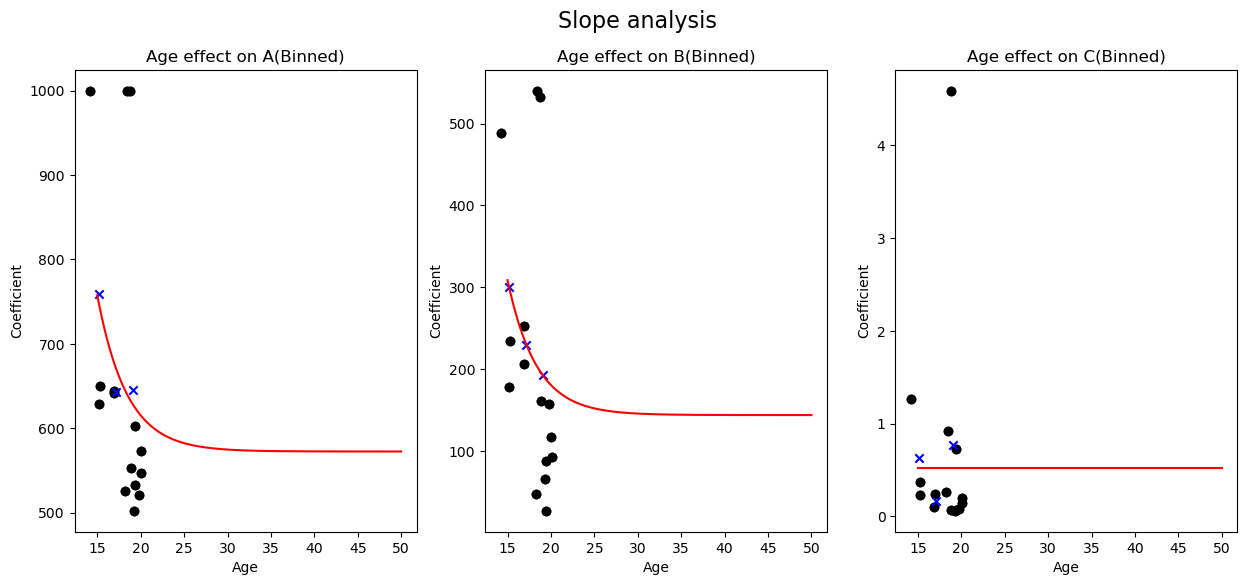

In [56]:

#LOG NO BINS


daf_c = data_allF[data_allF['Group']=='C']


#CONTROL SWA found

daf_c = daf_c[daf_c['Subject'].isin(daf_c['Subject'].value_counts()[daf_c['Subject'].value_counts() >= 20].index)]


daf_c['sAge'] = daf_c['Age']/50


def func(x, a, b, c):
    return a  - (b * np.exp(-x/c)) 




x_list = []
a_list = []
b_list = []
c_list = []



for name, Subject in daf_c.groupby('Id'):
    #plt.scatter(Subject.time_rel.values,Subject.Slope.values)
    x = Subject.time_rel.values
    y = Subject.Slope.values
      
    popt, pcov = curve_fit(func, x, y,bounds=([0,0,0],[1000,1000,5]))

    #plt.plot(x, func(x,popt[0],popt[1],popt[2]))
    coef_a = popt[0]
    coef_b = popt[1]
    coef_c = popt[2]
    

    x_list.append(Subject['Age'].unique()[0])
    a_list.append(coef_a)
    b_list.append(coef_b)
    c_list.append(coef_c)
   

fig, ax = plt.subplots(1, 3, figsize = (15, 6))


splot = 0
coef_names = ['A','B','C']

for coef_list in [a_list,b_list,c_list]:
    y_list = coef_list

    ax[splot].scatter(x_list, y_list, marker='o', c='black', label='individual B predictions')

    sorted_data = sorted(zip(x_list, y_list))
    x_sorted, y_sorted = zip(*sorted_data)
    x_sorted = np.array(x_sorted)
    y_sorted = np.array(y_sorted)


    num_bins = 3
    bin_edges = np.linspace(min(x_sorted), max(x_sorted), num_bins + 1)
    bin_indices = np.digitize(x_sorted, bin_edges)

    bin_means = [y_sorted[bin_indices == i].mean() for i in range(1, num_bins + 1)]
    bin_centers = [np.mean([bin_edges[i],bin_edges[i+1]]) for i in range(0, num_bins)]

    popt_t_bin, pcov_t_bin = curve_fit(func, bin_centers, bin_means, bounds=([-10000, -15000, 0], [10000, 0, 1000]))

    print(" _____________ Fitted Parameters " + coef_names[splot]+":")
    print("a:", popt_t_bin[0])
    print("b:", popt_t_bin[1])
    print("c:", popt_t_bin[2])
    


    x_ages = np.linspace(15,50,200)

    ax[splot].scatter(x_sorted, y_sorted, marker='o', c='black', label='Individual B predictions')
    ax[splot].scatter(bin_centers, bin_means, marker='x', c='blue', label='Mean values per bin')
    ax[splot].plot(x_ages, func(x_ages, popt_t_bin[0], popt_t_bin[1], popt_t_bin[2]), c='red', label='Exponential prediction')

    ax[splot].set_title('Age effect on ' + coef_names[splot] +'(Binned)')
    ax[splot].set_xlabel('Age')
    ax[splot].set_ylabel('Coefficient')
    


    splot = splot + 1


fig.suptitle("Slope analysis", fontsize=16)



/tmp/ipykernel_431155/3904100052.py:66: RuntimeWarning: Mean of empty slice.
  bin_means = [y_sorted[bin_indices == i].mean() for i in range(1, num_bins + 1)]
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: array must not contain infs or NaNs

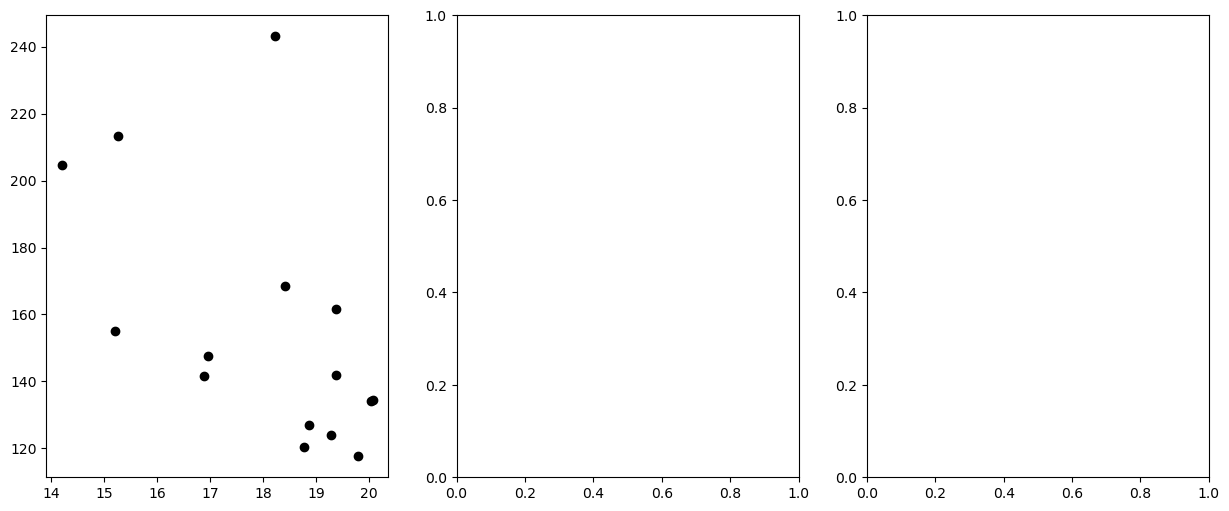

In [57]:
#LOG NO BINS AMPLITUDE


daf_c = data_allF[data_allF['Group']=='C']


#CONTROL SWA found

daf_c = daf_c[daf_c['Subject'].isin(daf_c['Subject'].value_counts()[daf_c['Subject'].value_counts() >= 20].index)]


daf_c['sAge'] = daf_c['Age']/50


def func(x, a, b, c):
    return a  - (b * np.exp(-x/c))


x_list = []
a_list = []
b_list = []
c_list = []



for name, Subject in daf_c.groupby('Id'):
    #plt.scatter(Subject.time_rel.values,Subject.Slope.values)
    x = Subject.time_rel.values
    y = Subject.PTP.values
      
    popt, pcov = curve_fit(func, x, y,bounds=([0,-1000,0],[1000,1000,5]))

    #plt.plot(x, func(x,popt[0],popt[1],popt[2]))
    coef_a = popt[0]
    coef_b = popt[1]
    coef_c = popt[2]

    x_list.append(Subject['Age'].unique()[0])
    a_list.append(coef_a)
    b_list.append(coef_b)
    c_list.append(coef_c)

fig, ax = plt.subplots(1, 3, figsize = (15, 6))




splot = 0
coef_names = ['A','B','C']

for coef_list in [a_list,b_list,c_list]:
    y_list = coef_list

    ax[splot].scatter(x_list, y_list, marker='o', c='black', label='individual B predictions')

    sorted_data = sorted(zip(x_list, y_list))
    x_sorted, y_sorted = zip(*sorted_data)
    x_sorted = np.array(x_sorted)
    y_sorted = np.array(y_sorted)


    num_bins = 7
    bin_edges = np.linspace(min(x_sorted), max(x_sorted), num_bins + 1)
    bin_indices = np.digitize(x_sorted, bin_edges)

    bin_means = [y_sorted[bin_indices == i].mean() for i in range(1, num_bins + 1)]
    bin_centers = [np.mean([bin_edges[i],bin_edges[i+1]]) for i in range(0, num_bins)]

    popt_t_bin, pcov_t_bin = curve_fit(func, bin_centers, bin_means, bounds=([-10000, -15000, 0], [10000, 0, 1000]))

    print(" _____________ Fitted Parameters " + coef_names[splot]+":")
    print("a:", popt_t_bin[0])
    print("b:", popt_t_bin[1])
    print("c:", popt_t_bin[2])

    x_ages = np.linspace(15,50,200)

    ax[splot].scatter(x_sorted, y_sorted, marker='o', c='black', label='Individual B predictions')
    ax[splot].scatter(bin_centers, bin_means, marker='x', c='blue', label='Mean values per bin')
    ax[splot].plot(x_ages, func(x_ages, popt_t_bin[0], popt_t_bin[1], popt_t_bin[2]), c='red', label='Exponential prediction')

    ax[splot].set_title('Age effect on ' + coef_names[splot] +'(Binned)')
    ax[splot].set_xlabel('Age')
    ax[splot].set_ylabel('Coefficient')
    ax[splot].legend()


    splot = splot + 1


fig.suptitle("Amplitude analysis", fontsize=16)


 _____________ Fitted Parameters A:
a: -252.0934087335723
b: -513.4837670469543
c: 999.999999999884
 _____________ Fitted Parameters B:
a: -2124.4243418064266
b: -2424.7518245606357
c: 999.99999999998
 _____________ Fitted Parameters C:
a: 0.24026608953412293
b: -3.100140563161025e-13
c: 0.06393808434233961


Text(0.5, 0.98, 'Amplitude analysis')

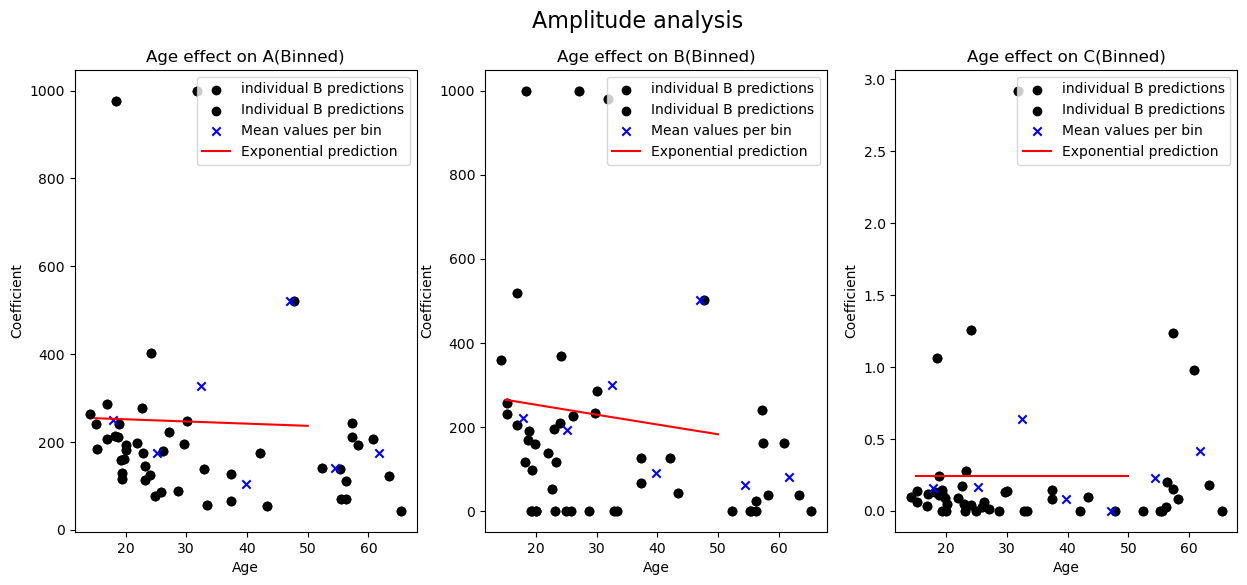

In [ ]:
#LOG NO BINS NUMBER


daf_c = data_allF[data_allF['Group']=='C']


#CONTROL SWA found

daf_c = daf_c[daf_c['Subject'].isin(daf_c['Subject'].value_counts()[daf_c['Subject'].value_counts() >= 20].index)]


daf_c['sAge'] = daf_c['Age']/50


def func(x, a, b, c):
    return a  - (b * np.exp(-x/c))


x_list = []
a_list = []
b_list = []
c_list = []



for name, Subject in daf_c.groupby('Id'):
    #plt.scatter(Subject.time_rel.values,Subject.Slope.values)

    bins_Subject = Subject.copy()
    bins_Subject['time_rel'] = pd.cut(bins_Subject['time_rel'], bins=8)  # Adjust the number of bins as needed
    bins_Subject = bins_Subject.groupby(['Session','Subject','time_rel'])['Slope'].count().reset_index()
    bdf_c['Group'] = bdf_c['Subject'].str[0]
    bins_Subject["time_rel_c"] = bins_Subject["time_rel"].apply(lambda x: x.mid).astype('object')
    times_Subject = bins_Subject['time_rel_c'].unique()
    
    x = bins_Subject.time_rel_c.values
    y = bins_Subject.Slope.values
      
    popt, pcov = curve_fit(func, x, y,bounds=([0,0,0],[1000,1000,5]))

    if popt[2] > 4:
        popt[2] = 0

    #plt.plot(x, func(x,popt[0],popt[1],popt[2]))
    coef_a = popt[0]
    coef_b = popt[1]
    coef_c = popt[2]

    x_list.append(Subject['Age'].unique()[0])
    a_list.append(coef_a)
    b_list.append(coef_b)
    c_list.append(coef_c)

fig, ax = plt.subplots(1, 3, figsize = (15, 6))




splot = 0
coef_names = ['A','B','C']

for coef_list in [a_list,b_list,c_list]:
    y_list = coef_list

    ax[splot].scatter(x_list, y_list, marker='o', c='black', label='individual B predictions')

    sorted_data = sorted(zip(x_list, y_list))
    x_sorted, y_sorted = zip(*sorted_data)
    x_sorted = np.array(x_sorted)
    y_sorted = np.array(y_sorted)


    num_bins = 7
    bin_edges = np.linspace(min(x_sorted), max(x_sorted), num_bins + 1)
    bin_indices = np.digitize(x_sorted, bin_edges)

    bin_means = [y_sorted[bin_indices == i].mean() for i in range(1, num_bins + 1)]
    bin_centers = [np.mean([bin_edges[i],bin_edges[i+1]]) for i in range(0, num_bins)]

    popt_t_bin, pcov_t_bin = curve_fit(func, bin_centers, bin_means, bounds=([-10000, -15000, 0], [10000, 0, 1000]))

    print(" _____________ Fitted Parameters " + coef_names[splot]+":")
    print("a:", popt_t_bin[0])
    print("b:", popt_t_bin[1])
    print("c:", popt_t_bin[2])

    x_ages = np.linspace(15,50,200)

    ax[splot].scatter(x_sorted, y_sorted, marker='o', c='black', label='Individual B predictions')
    ax[splot].scatter(bin_centers, bin_means, marker='x', c='blue', label='Mean values per bin')
    ax[splot].plot(x_ages, func(x_ages, popt_t_bin[0], popt_t_bin[1], popt_t_bin[2]), c='red', label='Exponential prediction')

    ax[splot].set_title('Age effect on ' + coef_names[splot] +'(Binned)')
    ax[splot].set_xlabel('Age')
    ax[splot].set_ylabel('Coefficient')
    ax[splot].legend()


    splot = splot + 1


fig.suptitle("Amplitude analysis", fontsize=16)

NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN


[]

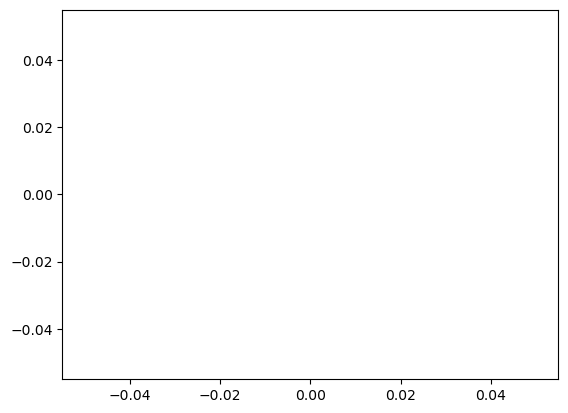

In [ ]:
#LOG WITH BINS




#CONTROL SWA found

bdf_c = bdf_c

bdf_c['Id'] = bdf_c['Subject'] + '_' + bdf_c['Session'].astype(str)
bdf_c['sAge'] = bdf_c['Age']/50


def func(x, a, b, c):

    return a  + (b * np.exp(-x/c))


for name, Subject in bdf_c.groupby('Id'):
    #plt.scatter(Subject.time_rel.values,Subject.Slope.values)
    x = Subject.time_rel_c.values
    y = Subject.Slope.values
    
    try:
        popt, pcov = curve_fit(func, x, y)
    

        #plt.plot(x, func(x,popt[0],popt[1],popt[2]))
        coef = popt[1]
        #age = Subject['sAge'].unique()[0]
        plt.scatter(age,coef, color='black')

    except:
        print('NAN')

    #print(Subject['sAge'].unique()[0])
    #print(coef)
   
    
    
plt.plot()

C48_1
[0.031 0.09375 0.156 0.2185 0.281 0.3435 0.406 0.4685]
301053.164525191
-300640.4419704635
2119.1723761972544


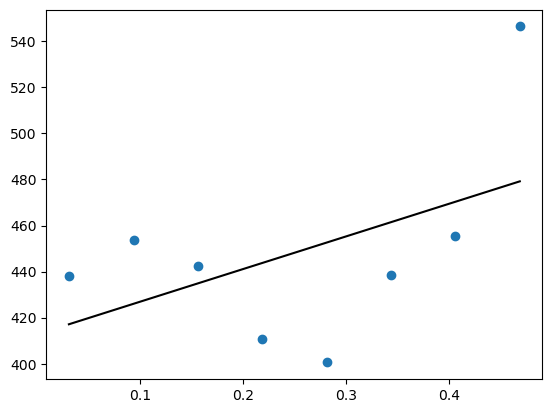

In [ ]:
print(name)
plt.scatter(Subject.time_rel_c,Subject.Slope.values)
print(x)
print(popt[0])
print(popt[1])
print(popt[2])
x = Subject.time_rel_c.values.astype(float)
plt.plot(x, func(x,popt[0],popt[1],popt[2]), color='black')

## SQRT PRED PLOT

In [ ]:
daf_c = data_allF[data_allF['Group']=='C']


#CONTROL SWA found

daf_c = daf_c[daf_c['Subject'].isin(daf['Subject'].value_counts()[daf_c['Subject'].value_counts() >= 20].index)]

daf_c['Id'] = daf_c['Subject'] + '_' + daf_c['Session'].astype(str)
daf_c['sAge'] = daf_c['Age']/50
daf_c['sAge2'] = daf_c['sAge']**2
daf_c['sAge3'] = daf_c['sAge']**3
daf_c['sAge4'] = daf_c['sAge']**4
daf_c['sqrt_t'] = np.sqrt(daf_c['time_rel'])
sAge_values = np.arange(0.2,1,0.01)
sAge_values2 = sAge_values**2
sAge_values3 = sAge_values**3
sAge_values4 = sAge_values**4


for name, Subject in daf_c.groupby('Id'):
    model_id = Lm('Slope ~ sqrt_t', data=Subject)
    result = model_id.fit()
    coef = result['Estimate'][1]
    #age = Subject['sAge'].unique()[0]
    plt.scatter(age,coef, color='black')

#Sqrt deg 1:

model1 = Lm('Slope ~ sqrt_t * (sAge)', data=daf_c)
model1.fit()
plt.plot(sAge_values, model1.coefs['Estimate'][1] 
                                                + model1.coefs['Estimate'][3]*sAge_values 
                                                ,label = 'deg1')

#Sqrt deg 2:

model2 = Lm('Slope ~ sqrt_t * (sAge + sAge2)', data=daf_c)
model2.fit()
plt.plot(sAge_values, model2.coefs['Estimate'][1] 
                                                + model2.coefs['Estimate'][4]*sAge_values 
                                                + model2.coefs['Estimate'][5]*sAge_values2 
                                                ,label = 'deg2')

#Sqrt deg 3:

model3 = Lm('Slope ~ sqrt_t * (sAge + sAge2 + sAge3)', data=daf_c)
model3.fit()
plt.plot(sAge_values, model3.coefs['Estimate'][1] 
                                                + model3.coefs['Estimate'][5]*sAge_values
                                                + model3.coefs['Estimate'][6]*sAge_values2
                                                + model3.coefs['Estimate'][7]*sAge_values3
                                                ,label = 'deg3')


#Sqrt deg 4:

model4 = Lm('Slope ~ sqrt_t * (sAge + sAge2 + sAge3 + sAge4)', data=daf_c)
model4.fit()
plt.plot(sAge_values, model4.coefs['Estimate'][1] 
                                                + model4.coefs['Estimate'][6]*sAge_values 
                                                + model4.coefs['Estimate'][7]*sAge_values2
                                                + model4.coefs['Estimate'][8]*sAge_values3
                                                + model4.coefs['Estimate'][9]*sAge_values4
                                                ,label = 'deg4')

plt.ylim([-300,700])
plt.legend()
plt.show()





IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

## LINE PRED PLOT

/tmp/ipykernel_2747101/2835078309.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daf_c['Id'] = daf_c['Subject'] + '_' + daf_c['Session'].astype(str)
/tmp/ipykernel_2747101/2835078309.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daf_c['sAge'] = daf_c['Age']/50
/tmp/ipykernel_2747101/2835078309.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

Formula: Slope~time_rel

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 2047	 R^2: 0.001	 R^2_adj: 0.000

Log-likelihood: -13446.054 	 AIC: 26896.108	 BIC: 26907.356

Fixed effects:

Formula: Slope~time_rel

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 902	 R^2: 0.003	 R^2_adj: 0.001

Log-likelihood: -5807.964 	 AIC: 11619.929	 BIC: 11629.538

Fixed effects:

Formula: Slope~time_rel

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 466	 R^2: 0.003	 R^2_adj: 0.000

Log-likelihood: -2972.719 	 AIC: 5949.438	 BIC: 5957.726

Fixed effects:

Formula: Slope~time_rel

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 2500	 R^2: 0.002	 R^2_adj: 0.001

Log-likelihood: -16762.757 	 AIC: 33529.515	 BI

/tmp/ipykernel_2747101/2835078309.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result['Estimate'][1]
/tmp/ipykernel_2747101/2835078309.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result['Estimate'][1]
/tmp/ipykernel_2747101/2835078309.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result['Estimate'][1]
/tmp/ipykernel_2747101/2835078309.py:17: FutureWarning: Series.__getitem__ treating keys

Formula: Slope~time_rel

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 1130	 R^2: 0.000	 R^2_adj: -0.001

Log-likelihood: -7311.558 	 AIC: 14627.116	 BIC: 14637.176

Fixed effects:

Formula: Slope~time_rel

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 1701	 R^2: 0.001	 R^2_adj: 0.001

Log-likelihood: -10866.761 	 AIC: 21737.521	 BIC: 21748.399

Fixed effects:

Formula: Slope~time_rel

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 4434	 R^2: 0.024	 R^2_adj: 0.024

Log-likelihood: -29964.563 	 AIC: 59933.127	 BIC: 59945.921

Fixed effects:

Formula: Slope~time_rel

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 2443	 R^2: 0.000	 R^2_adj: -0.000

Log-likelihood: -15994.865 	 AIC: 31993.

/tmp/ipykernel_2747101/2835078309.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result['Estimate'][1]
/tmp/ipykernel_2747101/2835078309.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result['Estimate'][1]
/tmp/ipykernel_2747101/2835078309.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result['Estimate'][1]
/tmp/ipykernel_2747101/2835078309.py:25: FutureWarning: Series.__getitem__ treating keys

Formula: Slope~time_rel*(sAge)

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 70885	 R^2: 0.056	 R^2_adj: 0.056

Log-likelihood: -471102.749 	 AIC: 942213.498	 BIC: 942250.174

Fixed effects:

Formula: Slope~time_rel*(sAge+sAge2)

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 70885	 R^2: 0.059	 R^2_adj: 0.059

Log-likelihood: -471007.692 	 AIC: 942027.384	 BIC: 942082.397

Fixed effects:

Formula: Slope~time_rel*(sAge+sAge2+sAge3)

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 70885	 R^2: 0.061	 R^2_adj: 0.061

Log-likelihood: -470926.638 	 AIC: 941869.275	 BIC: 941942.626

Fixed effects:



/tmp/ipykernel_2747101/2835078309.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(sAge_values, model3.coefs['Estimate'][1]
/tmp/ipykernel_2747101/2835078309.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  + model3.coefs['Estimate'][5]*sAge_values
/tmp/ipykernel_2747101/2835078309.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  + model3.coefs['Estimate'][6]*sAge_values2
/tmp/ipykernel_2747101/2835078309.py:45:

Formula: Slope~time_rel*(sAge+sAge2+sAge3+sAge4)

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 70885	 R^2: 0.062	 R^2_adj: 0.062

Log-likelihood: -470896.791 	 AIC: 941813.582	 BIC: 941905.270

Fixed effects:



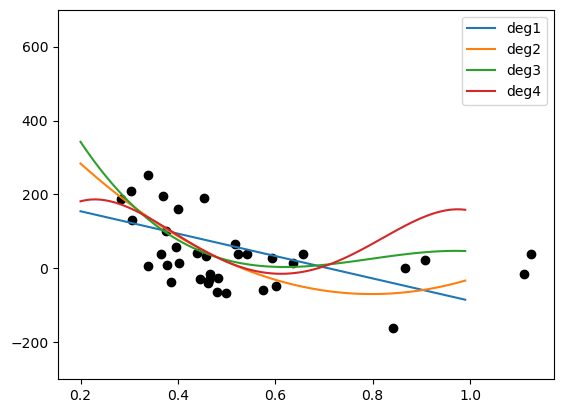

In [ ]:
daf_c = data_allF[data_allF['Group']=='C']
daf_c['Id'] = daf_c['Subject'] + '_' + daf_c['Session'].astype(str)
daf_c['sAge'] = daf_c['Age']/50
daf_c['sAge2'] = daf_c['sAge']**2
daf_c['sAge3'] = daf_c['sAge']**3
daf_c['sAge4'] = daf_c['sAge']**4
daf_c['sqrt_t'] = np.sqrt(daf_c['time_rel'])
sAge_values = np.arange(0.2,1,0.01)
sAge_values2 = sAge_values**2
sAge_values3 = sAge_values**3
sAge_values4 = sAge_values**4


for name, Subject in daf_c.groupby('Id'):
    model_id = Lm('Slope ~ time_rel', data=Subject)
    result = model_id.fit()
    coef = result['Estimate'][1]
    #age = Subject['sAge'].unique()[0]
    plt.scatter(age,coef, color='black')

#Sqrt deg 1:

model1 = Lm('Slope ~ time_rel * (sAge)', data=daf_c)
model1.fit()
plt.plot(sAge_values, model1.coefs['Estimate'][1] 
                                                + model1.coefs['Estimate'][3]*sAge_values 
                                                ,label = 'deg1')

#Sqrt deg 2:

model2 = Lm('Slope ~ time_rel * (sAge + sAge2)', data=daf_c)
model2.fit()
plt.plot(sAge_values, model2.coefs['Estimate'][1] 
                                                + model2.coefs['Estimate'][4]*sAge_values 
                                                + model2.coefs['Estimate'][5]*sAge_values2 
                                                ,label = 'deg2')

#Sqrt deg 3:

model3 = Lm('Slope ~ time_rel * (sAge + sAge2 + sAge3)', data=daf_c)
model3.fit()
plt.plot(sAge_values, model3.coefs['Estimate'][1] 
                                                + model3.coefs['Estimate'][5]*sAge_values
                                                + model3.coefs['Estimate'][6]*sAge_values2
                                                + model3.coefs['Estimate'][7]*sAge_values3
                                                ,label = 'deg3')


#Sqrt deg 4:

model4 = Lm('Slope ~ time_rel * (sAge + sAge2 + sAge3 + sAge4)', data=daf_c)
model4.fit()
plt.plot(sAge_values, model4.coefs['Estimate'][1] 
                                                + model4.coefs['Estimate'][6]*sAge_values 
                                                + model4.coefs['Estimate'][7]*sAge_values2
                                                + model4.coefs['Estimate'][8]*sAge_values3
                                                + model4.coefs['Estimate'][9]*sAge_values4
                                                ,label = 'deg4')

plt.ylim([-300,700])
plt.legend()
plt.show()


## LOG PRED PLOT

/tmp/ipykernel_2747101/38719194.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daf_c['Id'] = daf_c['Subject'] + '_' + daf_c['Session'].astype(str)
/tmp/ipykernel_2747101/38719194.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daf_c['sAge'] = daf_c['Age']/50


36
36
36


[]

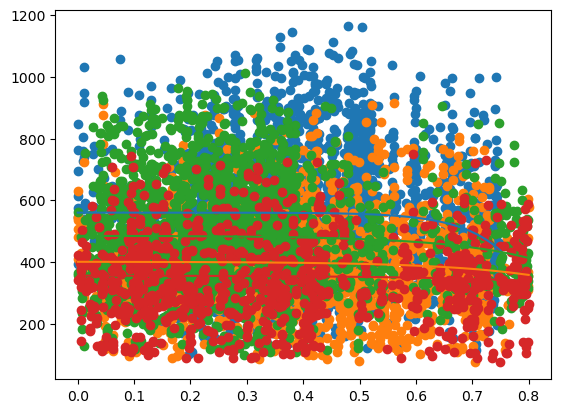

In [ ]:
daf_c = data_allF[data_allF['Group']=='C']
daf_c['Id'] = daf_c['Subject'] + '_' + daf_c['Session'].astype(str)
daf_c['sAge'] = daf_c['Age']/50




def func(x, a, b, c):
    return a  + (b * np.exp(-x/c))

c = 0
f = 0
g = 0

for name, Subject in daf_c.groupby('Id'):
    c = c +1

    #plt.scatter(Subject.time_rel.values,Subject.Slope.values)
    x = Subject.time_rel.values
    y = Subject.Slope.values

      
    popt, pcov = curve_fit(func, x, y)
    g = g + 1
    #plt.plot(x, func(x,popt[0],popt[1],popt[2]))
    coef = 1/popt[1]
    #age = Subject['sAge'].unique()[0]
    #plt.scatter(age,coef, color='black')

    f = f + 1
    #print(Subject['sAge'].unique()[0])
    #print(coef)

    if coef < -1:
        plt.scatter(Subject.time_rel.values,Subject.Slope.values)
        plt.plot(x, func(x,popt[0],popt[1],popt[2]))
    
    
print(c)
print(f)
print(g)
    
plt.plot()

# NO BINS MODEL

In [ ]:
daf_c = data_allF[data_allF['Group']=='C']
daf_c['Id'] = daf_c['Subject'] + '_' + daf_c['Session'].astype(str)
daf_c['sAge'] = daf_c['Age']/50
daf_c.head()

/tmp/ipykernel_2747101/2859326843.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daf_c['Id'] = daf_c['Subject'] + '_' + daf_c['Session'].astype(str)
/tmp/ipykernel_2747101/2859326843.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daf_c['sAge'] = daf_c['Age']/50


index   Wave     Start  NegPeak  MidCrossing  PosPeak      End  \
47  2831880  12769  0.673000  2423.08      2423.34  2423.57  2423.91   
48  2830582  11471  0.679381  2446.06      2446.33  2446.52  2447.30   
49  2833475  14364  0.679381  2446.04      2446.28  2446.48  2446.75   
50  2835266  16155  0.679381  2446.03      2446.27  2446.47  2446.75   
51  2836802  17691  0.679381  2446.02      2446.25  2446.47  2446.79   

    Duration  ValNegPeak  ValPosPeak         PTP       Slope  Frequency  \
47      1.11  -46.707747   32.177395   78.885141  303.404390   0.900901   
48      1.53  -89.754462   38.805616  128.560078  476.148436   0.653595   
49      0.98 -117.820316   70.414380  188.234695  784.311231   1.020408   
50      0.98 -111.116778   73.118567  184.235346  767.647273   1.020408   
51      1.02  -55.017271   42.728858   97.746129  424.983169   0.980392   

    Stage Channel  IdxChannel Group Subject Session    Age Machine  \
47      3      F3           7     C     C02       1  22.91       O   
48      3      F7           6     C     C02       1  22.91       O   
49      3      Fz           8     C     C02       1  22.91       O   
50      3      F4           9     C     C02       1  22.91       O   
51      3      F8          10     C     C02       1  22.91       O   

   ConfArousal Position  N3_times  time_rel     Id    sAge  
47           0        F     0.673  0.000000  C02_1  0.4582  
48           0        F     0.673  0.006381  C02_1  0.4582  
49           0        F     0.673  0.006381  C02_1  0.4582  
50           0        F     0.673  0.006381  C02_1  0.4582  
51           0        F     0.673  0.006381  C02_1  0.4582

(array([7629., 2848., 7436., 3114., 9113., 7836.,    0., 3870., 9012.,
        2762.,  492., 3834., 3674.,  902.,  466., 2500., 1130., 1701.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,   88.,
         419.,    0.,  256.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0., 1803.]),
 array([0.284  , 0.30505, 0.3261 , 0.34715, 0.3682 , 0.38925, 0.4103 ,
        0.43135, 0.4524 , 0.47345, 0.4945 , 0.51555, 0.5366 , 0.55765,
        0.5787 , 0.59975, 0.6208 , 0.64185, 0.6629 , 0.68395, 0.705  ,
        0.72605, 0.7471 , 0.76815, 0.7892 , 0.81025, 0.8313 , 0.85235,
        0.8734 , 0.89445, 0.9155 , 0.93655, 0.9576 , 0.97865, 0.9997 ,
        1.02075, 1.0418 , 1.06285, 1.0839 , 1.10495, 1.126  ]),
 <BarContainer object of 40 artists>)

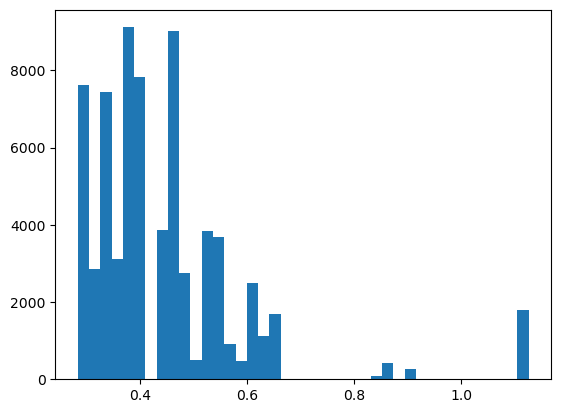

In [ ]:
plt.hist(daf_c['sAge'],40)

# UP TO deg 5

In [ ]:


model_sq = Lmer('Slope ~ time_rel * (sAge + I(sAge^2) + I(sAge^3) + I(sAge^4) + I(sAge^5)) + (1|Subject:Session)', data=daf_c)



# Fit and print an R/statsmodels style summary 
# with t/z-tests, CIs, and p-values
model_sq.fit()
print(model_sq.coefs)


# Access model attributes
print('BIC: ' + str(model_sq.BIC))
model_sq.residuals


/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "ConfArousal". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '


Linear mixed model fit by REML [’lmerMod’]
Formula: Slope~time_rel*(sAge+I(sAge^2)+I(sAge^3)+I(sAge^4)+I(sAge^5))+(1|Subject:Session)

Family: gaussian	 Inference: parametric

Number of observations: 70885	 Groups: {'Subject:Session': 36.0}

Log-likelihood: -468538.719 	 AIC: 937105.439

Random effects:

                        Name        Var      Std
Subject:Session  (Intercept)   2783.254   52.757
Residual                      32268.013  179.633

No random effect correlations specified

Fixed effects:

                        Estimate         2.5_ci        97.5_ci             SE  \
(Intercept)           545.230148   -4205.704435    5296.164730    2423.990757   
time_rel              650.151609   -1359.763086    2660.066304    1025.485525   
sAge                 2439.862933  -40785.782097   45665.507963   22054.305779   
I(sAge^2)          -18231.543279 -168347.025651  131883.939093   76590.939199   
I(sAge^3)           44263.778946 -204135.601478  292663.159371  126736.706585   
I(s

/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


array([-182.42663567,   -9.98758106,  298.17521341, ...,   79.22585185,
         53.6560655 ,  190.42256289])

/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be remov

<Axes: xlabel='Estimate'>

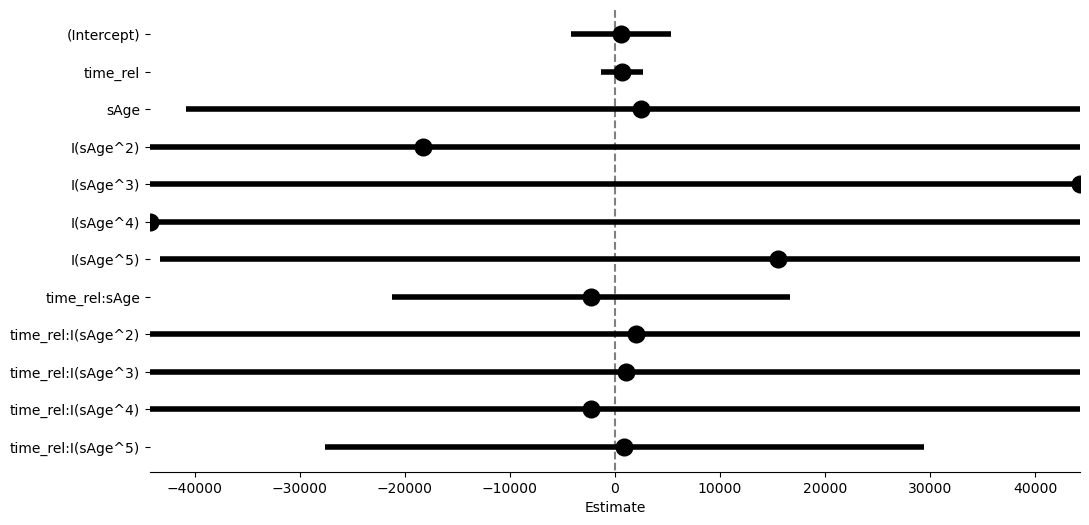

In [ ]:
model_sq.plot_summary()

In [ ]:
plt.figure(figsize=(10, 6))

sAge_values = np.arange(0.2,0.8,0.1)
unique_time_rel_values = daf_c['time_rel'].unique()
123922

for age in sAge_values:
    times = np.linspace(min(daf_c['time_rel'].unique()), max(daf_c['time_rel'].unique()),100)

    times_out = []
    while len(times_out) < 15362:
        times_out.extend(times)


    times_out = times_out[:15362]

    df_pred = pd.DataFrame({'time_rel': times_out})
    df_pred['sAge'] = age
    df_pred['Slope'] = model_sq.predict(df_pred, skip_data_checks=True)
    plt.plot(df_pred['time_rel'][0:100],df_pred['Slope'][0:100], label = round(age*50,2))


plt.xlabel('Time')
plt.ylabel('Predicted Slopes')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()    


/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "ConfArousal". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '


ValueError: Length of values (70885) does not match length of index (15362)

<Figure size 1000x600 with 0 Axes>

# Up to 2 deg BOTH

In [ ]:
model_sq = Lmer('Slope ~ time_rel * (sAge + I(sAge^2)) + I(sqrt(time_rel)) * (sAge + I(sAge^2)) + (1|Subject:Session)', data=daf_c)



# Fit and print an R/statsmodels style summary 
# with t/z-tests, CIs, and p-values
model_sq.fit()
print(model_sq.coefs)


# Access model attributes
print('BIC: ' + str(model_sq.BIC))
model_sq.residuals


Linear mixed model fit by REML [’lmerMod’]
Formula: Slope~time_rel*(sAge+I(sAge^2))+I(sqrt(time_rel))*(sAge+I(sAge^2))+(1|Subject:Session)

Family: gaussian	 Inference: parametric

Number of observations: 15362	 Groups: {'Subject:Session': 32.0}

Log-likelihood: -102381.231 	 AIC: 204784.462

Random effects:

                        Name        Var      Std
Subject:Session  (Intercept)   3953.781   62.879
Residual                      36005.746  189.752

No random effect correlations specified

Fixed effects:

                                Estimate       2.5_ci      97.5_ci  \
(Intercept)                   305.326359  -195.244724   805.897442   
time_rel                      -28.407445 -1186.611038  1129.796147   
sAge                           82.758625 -1890.453768  2055.971018   
I(sAge^2)                     148.229150 -1690.067729  1986.526028   
I(sqrt(time_rel))             813.992976  -606.018835  2234.004788   
time_rel:sAge                -603.437313 -5307.231487  4100.3568

/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


array([-247.15359379,  -48.63753464,   16.24605027, ...,  338.3323455 ,
        -76.30385387, -163.44301389])

/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be remov

<Axes: xlabel='Estimate'>

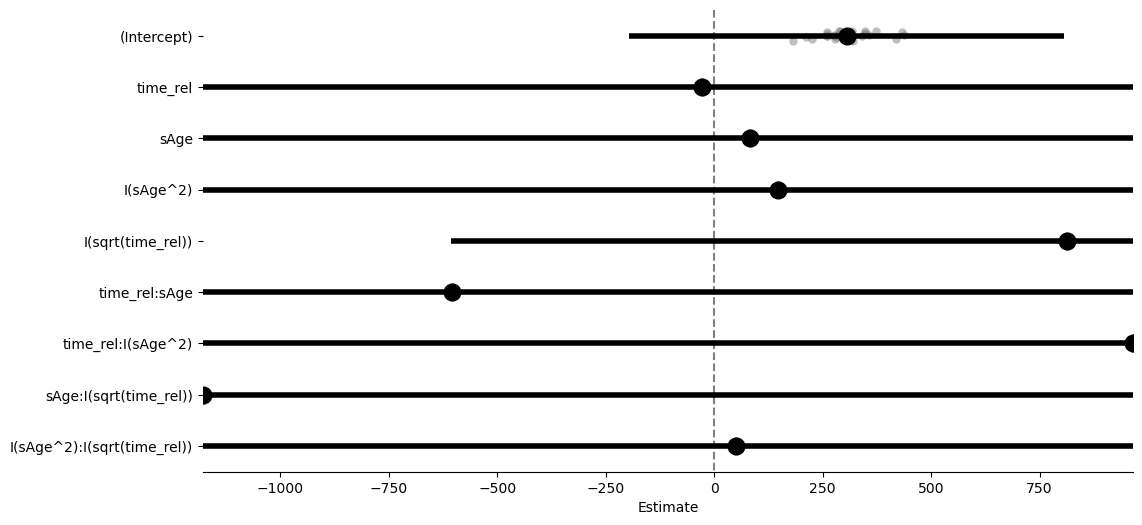

In [ ]:
model_sq.plot_summary()

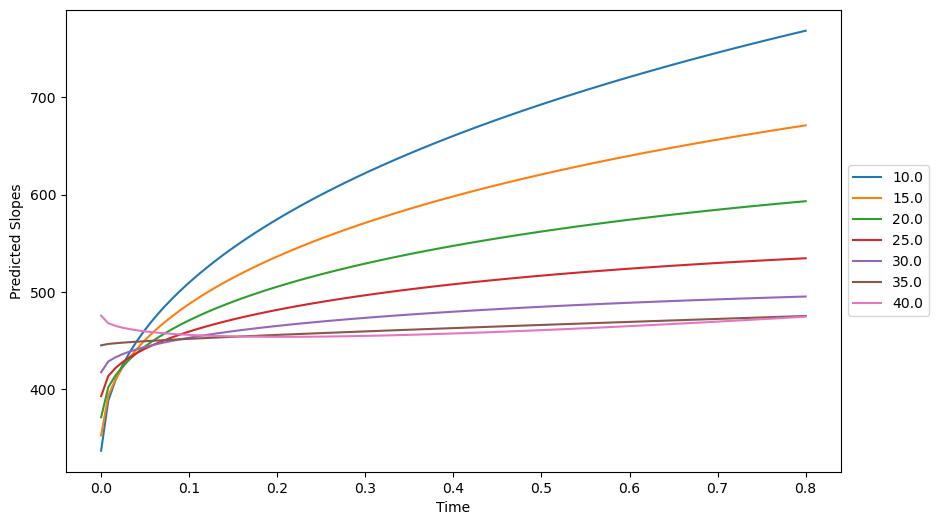

In [ ]:
plt.figure(figsize=(10, 6))

sAge_values = np.arange(0.2,0.8,0.1)
unique_time_rel_values = daf_c['time_rel'].unique()
123922

for age in sAge_values:
    times = np.linspace(min(daf_c['time_rel'].unique()), max(daf_c['time_rel'].unique()),100)
    
    times_out = []
    while len(times_out) < 15362:
        times_out.extend(times)


    times_out = times_out[:15362]

    df_pred = pd.DataFrame({'time_rel': times_out})
    df_pred['sAge'] = age
    df_pred['Slope'] = model_sq.predict(df_pred, skip_data_checks=True)
    plt.plot(df_pred['time_rel'][0:100],df_pred['Slope'][0:100], label = round(age*50,2))


plt.xlabel('Time')
plt.ylabel('Predicted Slopes')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()    


# SQRT 5 Deg BOTH

In [ ]:


model_sq = Lmer('Slope ~ I(sqrt(time_rel)) * (sAge + I(sAge^2) +  I(sAge^3)) + time_rel * (sAge + I(sAge^2) + I(sAge^3)) + (1|Subject:Session)', data=daf_c)



# Fit and print an R/statsmodels style summary 
# with t/z-tests, CIs, and p-values
model_sq.fit()
print(model_sq.coefs)


# Access model attributes
print('BIC: ' + str(model_sq.BIC))
model_sq.residuals


Linear mixed model fit by REML [’lmerMod’]
Formula: Slope~I(sqrt(time_rel))*(sAge+I(sAge^2)+I(sAge^3))+time_rel*(sAge+I(sAge^2)+I(sAge^3))+(1|Subject:Session)

Family: gaussian	 Inference: parametric

Number of observations: 15362	 Groups: {'Subject:Session': 32.0}

Log-likelihood: -102349.974 	 AIC: 204727.949

Random effects:

                        Name        Var      Std
Subject:Session  (Intercept)   3606.192   60.052
Residual                      36006.367  189.753

No random effect correlations specified

Fixed effects:

                                 Estimate        2.5_ci        97.5_ci  \
(Intercept)                     36.922543  -1799.604734    1873.449820   
I(sqrt(time_rel))             4522.657768   -701.952485    9747.268022   
sAge                          1904.851570  -9224.171641   13033.874781   
I(sAge^2)                    -3669.305727 -24993.713699   17655.102246   
I(sAge^3)                     2442.506488 -10357.671495   15242.684472   
time_rel            

/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


array([-258.63390099,  -57.65674197,   10.43682056, ...,  336.66618106,
        -77.97283668, -165.11606538])

/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be remov

<Axes: xlabel='Estimate'>

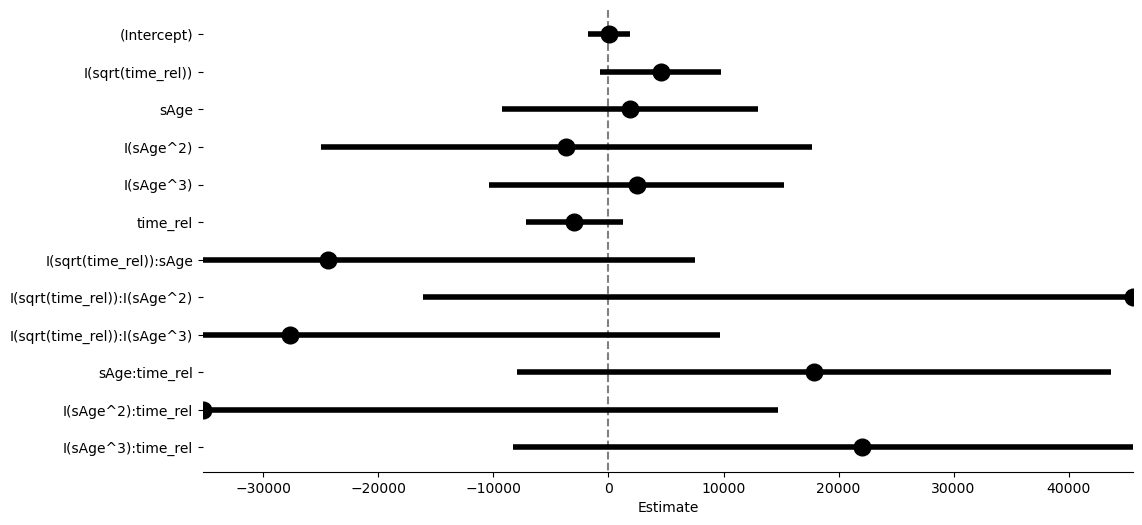

In [ ]:
model_sq.plot_summary()

In [ ]:
plt.figure(figsize=(10, 6))

sAge_values = np.arange(0.2,0.8,0.1)
unique_time_rel_values = daf_c['time_rel'].unique()
123922

for age in sAge_values:
    times = np.linspace(min(daf_c['time_rel'].unique()), max(daf_c['time_rel'].unique()),100)
    
    times_out = []
    while len(times_out) < 123921:
        times_out.extend(times)


    times_out = times_out[:123921]

    df_pred = pd.DataFrame({'time_rel': times_out})
    df_pred['sAge'] = age
    df_pred['Slope'] = model_sq.predict(df_pred, skip_data_checks=True)
    plt.plot(df_pred['time_rel'][0:100],df_pred['Slope'][0:100], label = round(age*50,2))


plt.xlabel('Time')
plt.ylabel('Predicted Slopes')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()    

ValueError: operands could not be broadcast together with shapes (15362,) (123921,) 

<Figure size 1000x600 with 0 Axes>

# SQRT deg 2

In [ ]:
model_sq = Lmer('Slope ~ I(sqrt(time_rel)) * (sAge + I(sAge^2)) + (1|Subject:Session)', data=daf_c)



# Fit and print an R/statsmodels style summary 
# with t/z-tests, CIs, and p-values
model_sq.fit()
print(model_sq.coefs)


# Access model attributes
print('BIC: ' + str(model_sq.BIC))
model_sq.residuals

Linear mixed model fit by REML [’lmerMod’]
Formula: Slope~I(sqrt(time_rel))*(sAge+I(sAge^2))+(1|Subject:Session)

Family: gaussian	 Inference: parametric

Number of observations: 123921	 Groups: {'Subject:Session': 32.0}

Log-likelihood: -818610.531 	 AIC: 1637237.061

Random effects:

                        Name        Var      Std
Subject:Session  (Intercept)   4269.829   65.344
Residual                      31984.732  178.843

No random effect correlations specified

Fixed effects:

                                Estimate       2.5_ci      97.5_ci  \
(Intercept)                   332.977855    58.379422   607.576289   
I(sqrt(time_rel))             644.881553   550.828292   738.934814   
sAge                           69.927264  -975.555671  1115.410200   
I(sAge^2)                     -11.091886  -945.498875   923.315104   
I(sqrt(time_rel)):sAge      -1453.831688 -1854.669336 -1052.994040   
I(sqrt(time_rel)):I(sAge^2)   913.942258   505.618396  1322.266121   

                 

/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


array([  96.03910818,  119.93726911, -146.7354911 , ..., -129.03346606,
       -166.11564097, -278.91066559])

/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be remov

<Axes: xlabel='Estimate'>

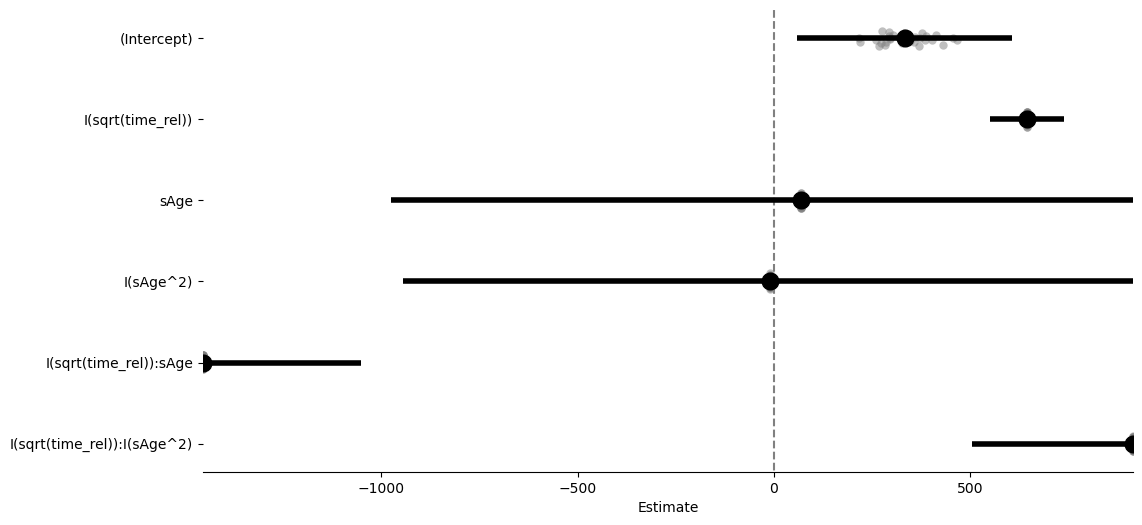

In [ ]:
model_sq.plot_summary()

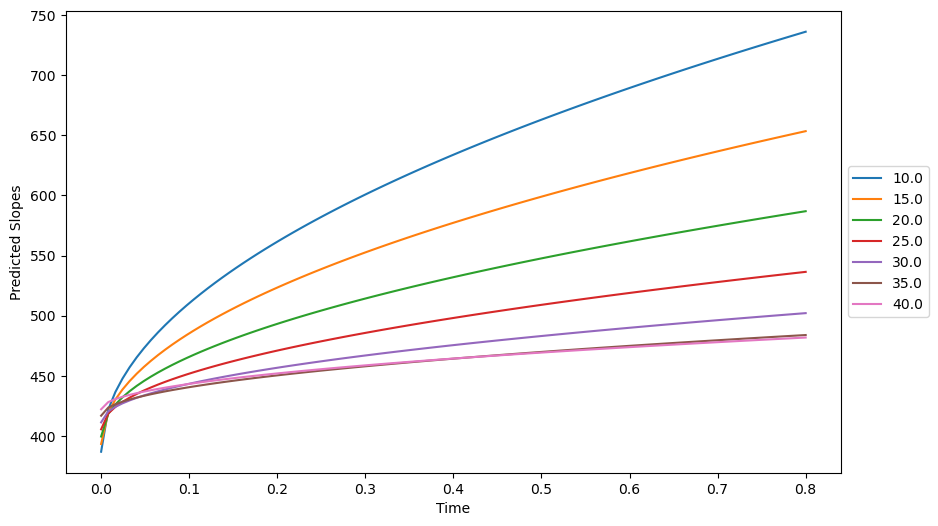

In [ ]:
plt.figure(figsize=(10, 6))

sAge_values = np.arange(0.2,0.8,0.1)
unique_time_rel_values = daf_c['time_rel'].unique()
123922

for age in sAge_values:
    times = np.linspace(min(daf_c['time_rel'].unique()), max(daf_c['time_rel'].unique()),100)
    
    times_out = []
    while len(times_out) < 123921:
        times_out.extend(times)


    times_out = times_out[:123921]

    df_pred = pd.DataFrame({'time_rel': times_out})
    df_pred['sAge'] = age
    df_pred['Slope'] = model_sq.predict(df_pred, skip_data_checks=True)
    plt.plot(df_pred['time_rel'][0:100],df_pred['Slope'][0:100], label = round(age*50,2))


plt.xlabel('Time')
plt.ylabel('Predicted Slopes')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()   